# DLMDWME01 - Fallstudie: Model Engineering

Der folgende Quellcode wurde im Rahmen der Bearbeitung der Fallstudie erstellt.
Dabei wurde die Aufgabenstellung 1 "Erstellen eines Prognosemodells des Kreditkartenzahlungsverkehr für Online-Einkäufe" gewählt.

## Abschnitt 0: Vorbereitungen
Installation und Import der benötigten Packages.

In [2]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install association_metrics
!pip install numpy
!pip install de-feiertage
!pip install imblearn
!pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import association_metrics as am
import numpy as np
from deutschland import feiertage
from deutschland.feiertage.api import default_api
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler

/Users/christian.koeninger/Entwicklung/Projekte/DLMDWME01/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Definieren einer globalen Variable, über welche gesteuert werden kann, ob komplexe Berechnungen wie GridSearch und Modelltraining ausgeschalten werden, um Testzyklen zu verkürzen. 

In [4]:
debug = False

Auschalten der Warnungsmeldungen, um die Ausgaben im Notebook für die Fallstudie auf den Datenoutput zu beschränken. Für die Entwicklung und den Produktiveinsatz sollte der Befehl dringend entfernt werden, um eventuell wichtige Warnungen bemerken zu können.

In [5]:
warnings.filterwarnings('ignore')

## Abschnitt 1: Explorative Datenanalyse (EDA)
Die Daten werden aus der CSV-Datei geladen, wobei dies in einer Enterprise-Umgebung auch aus einer Datenbank oder über eine API geschehen könnte.

In [6]:
df_original = pd.read_csv('../daten/PSP_Jan_Feb_2019.csv', sep=";")
df_original.columns = df_original.columns.str.replace('Unnamed: 0', 'index')
df_original.head()

,index,tmsp,country,amount,success,PSP,3D_secured,card
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


Nun werden die einzelnen Merkmale untersucht und hinsichtlich der Auswirkungen auf den Erfolg einer Transaktion geprüft.

Überblick über die grundsätzliche Verteilung von Erfolg und Misserfolg einzelner Transaktionen.

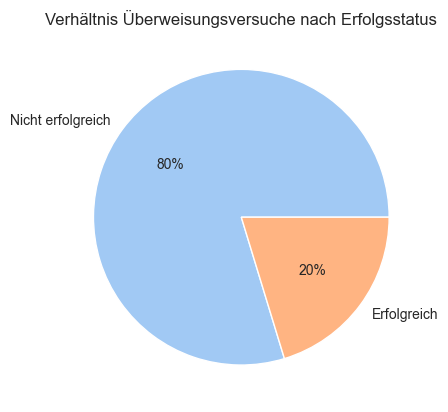

In [7]:
# Gruppierung der Daten
df_summarized = df_original.groupby('success')['index'].count()
# Festlegung von Titel, Label und Farben
labels = ['Nicht erfolgreich', 'Erfolgreich']
colors = sns.color_palette('pastel')[0:2]
plt.title('Verhältnis Überweisungsversuche nach Erfolgsstatus')
# Erstellung des Diagramms
plt.pie(df_summarized, labels=labels, colors=colors, autopct='%.0f%%')

plt.show()

Verhältnis der erfolgreichen / nicht erfolgreichen Überweisungen nach Ländern. 

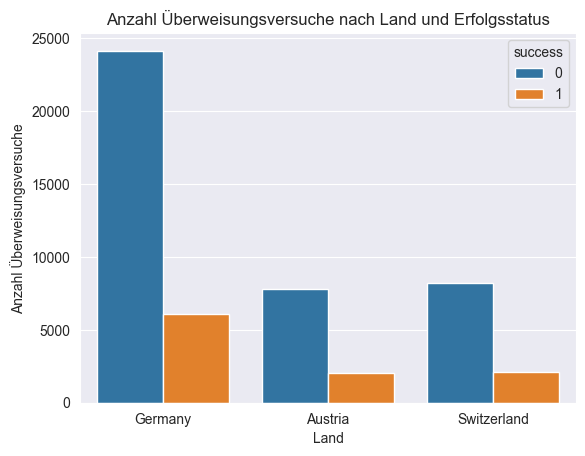

In [8]:
# Erstellung des Diagramms
sns.countplot(data=df_original, x='country', hue='success')
# Festlegung von Titel und Label
plt.xlabel('Land')
plt.ylabel('Anzahl Überweisungsversuche')
plt.title('Anzahl Überweisungsversuche nach Land und Erfolgsstatus')

plt.show()

Verhältnis der erfolgreichen / nicht erfolgreichen Überweisungen nach Kartentyp. 

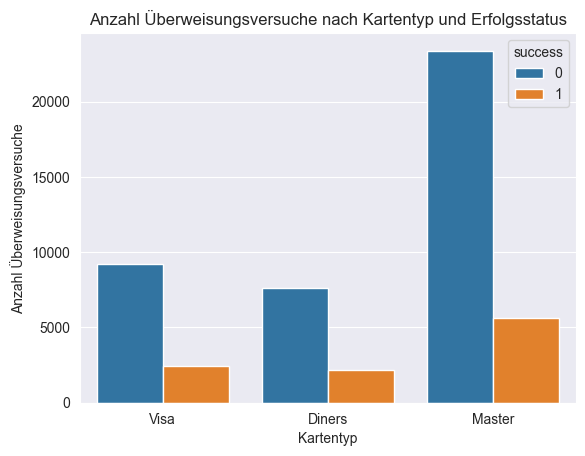

In [9]:
# Erstellung des Diagramms
sns.countplot(data=df_original, x='card', hue='success')
# Festlegung von Titel und Label
plt.xlabel('Kartentyp')
plt.ylabel('Anzahl Überweisungsversuche')
plt.title('Anzahl Überweisungsversuche nach Kartentyp und Erfolgsstatus')

plt.show()

Verhältnis der erfolgreichen / nicht erfolgreichen Überweisungen nach Identifizierungsart. 

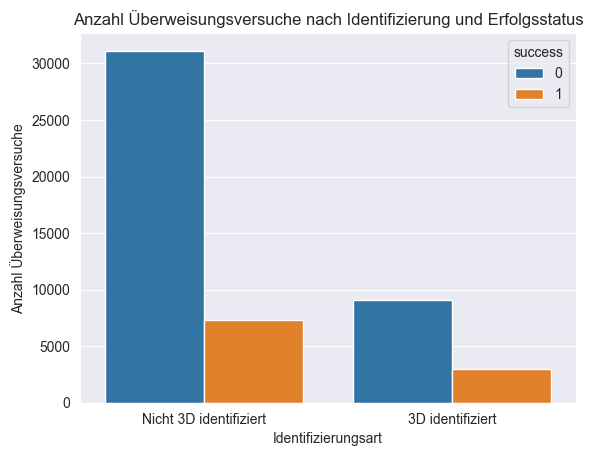

In [10]:
# Erstellung des Diagramms
sns.countplot(data=df_original, x='3D_secured', hue='success')
# Festlegung von Titel und Label
plt.xticks([0, 1], ['Nicht 3D identifiziert', '3D identifiziert'])
plt.xlabel('Identifizierungsart')
plt.ylabel('Anzahl Überweisungsversuche')
plt.title('Anzahl Überweisungsversuche nach Identifizierung und Erfolgsstatus')

plt.show()

Histogramm zur Darstellung der Verteilung der Umsätze und unterteilt nach Erfolgsstatus.

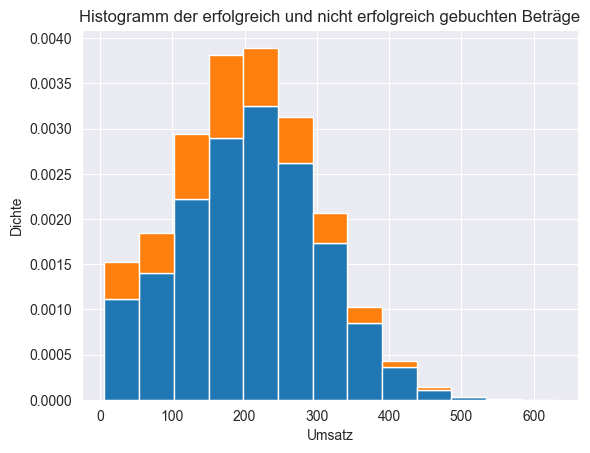

In [11]:
# Erstellung des Diagramms
fig, ax = plt.subplots(1, 1)
plt.hist([df_original[df_original.success == 0].amount, df_original[df_original.success == 1].amount], 13, stacked=True,
         density=True)
# Festlegung des Titels
plt.xlabel('Umsatz')
plt.ylabel('Dichte')
plt.title('Histogramm der erfolgreich und nicht erfolgreich gebuchten Beträge')

plt.show()

Verteilung aller Überweisungsversuche auf die Stunde der Ausführung

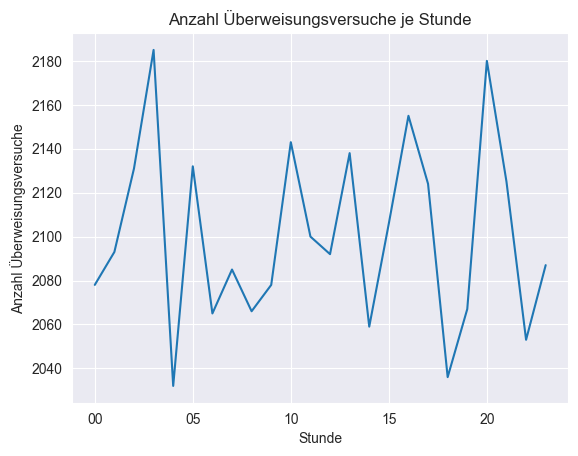

In [12]:
# Gruppierung der Daten
df_time = df_original.copy()
df_time['datetime'] = pd.to_datetime(df_time['tmsp'])
df_time['hour'] = df_time['datetime'].dt.strftime('%H')
df_summarized = df_time.groupby('hour')['index'].count()
# Erstellung des Diagramms
df_summarized.plot(kind='line')
# Festlegung von Titel und Label
plt.xlabel('Stunde')
plt.ylabel('Anzahl Überweisungsversuche')
plt.title('Anzahl Überweisungsversuche je Stunde')

plt.show()

Untersuchung der erfolgreichen / nicht erfolgreichen Zahlungen nach Uhrzeit für jeden PSP.

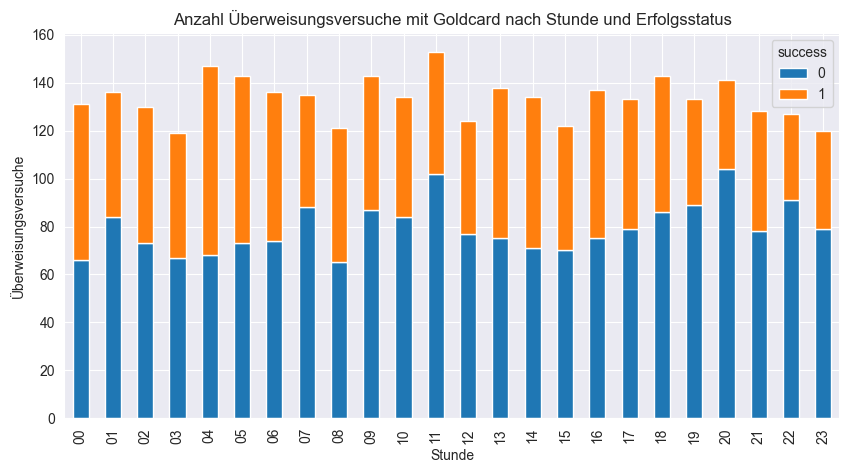

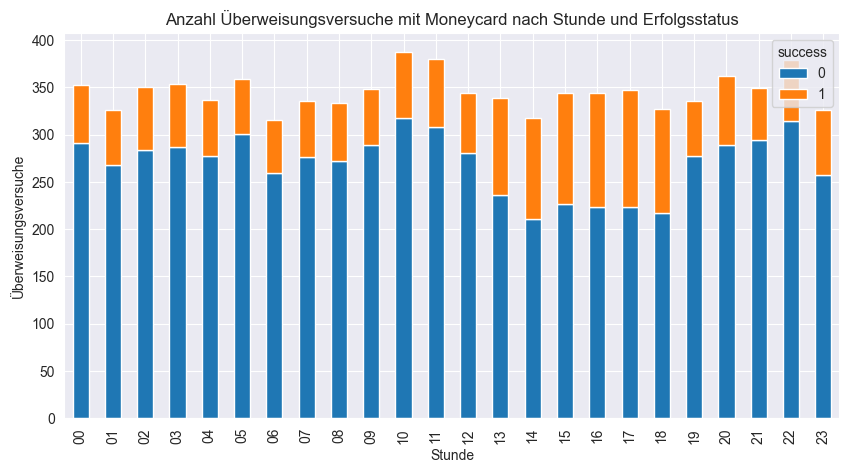

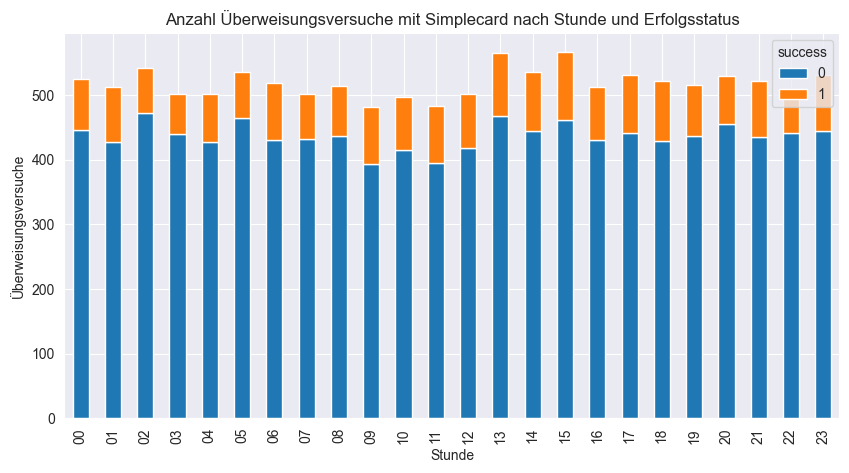

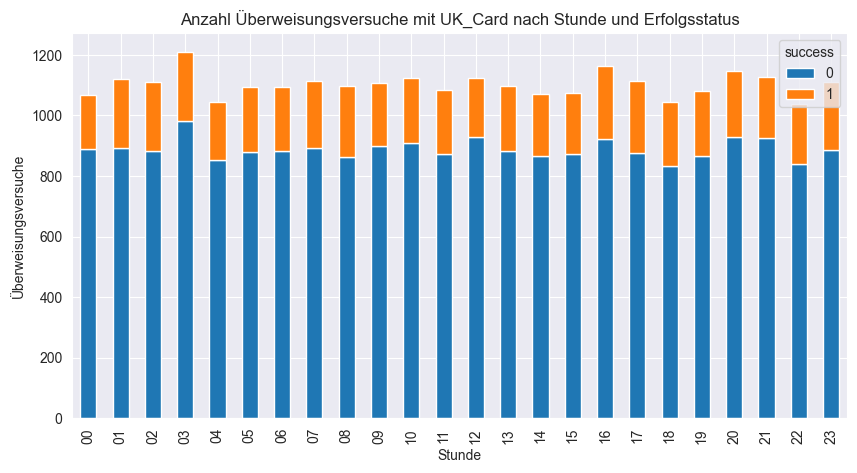

In [13]:
def create_time_plot_for_psp(psp):
    # Gruppierung der Daten
    df_grouped = df_time[df_time['PSP'] == psp].groupby(['hour', 'success'])['index'].count().reset_index()
    df_pivot = pd.pivot_table(df_grouped, values='index', index=['hour'], columns=['success'], fill_value=0)

    # Erstellung des Diagramms
    ax = df_pivot.plot(kind='bar', stacked=True, figsize=(10, 5))

    # Festlegung von Titel und Label
    ax.set_xlabel('Stunde')
    ax.set_ylabel('Überweisungsversuche')
    plt.title('Anzahl Überweisungsversuche mit ' + psp + ' nach Stunde und Erfolgsstatus')

    plt.show()


# Erstellung der Diagramme für alle PSP
create_time_plot_for_psp('Goldcard')
create_time_plot_for_psp('Moneycard')
create_time_plot_for_psp('Simplecard')
create_time_plot_for_psp('UK_Card')

Untersuchung der Anzahl an Überweisungen je Monat.

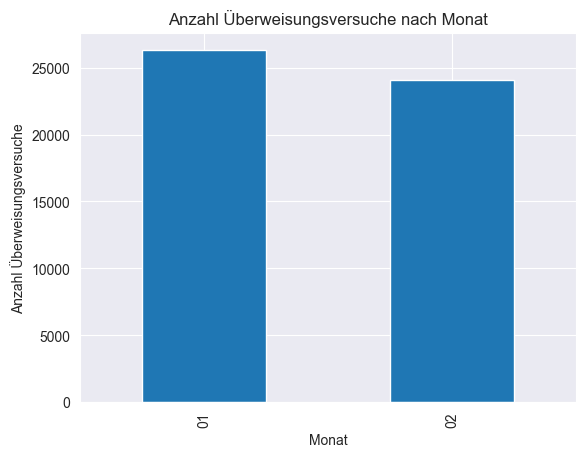

In [14]:
# Gruppierung der Daten
df_time['month'] = df_time['datetime'].dt.strftime('%m')
df_summarized = df_time.groupby('month')['index'].count()
# Erstellung des Diagramms
df_summarized.plot(kind='bar')
# Festlegung von Titel und Label
plt.xlabel('Monat')
plt.ylabel('Anzahl Überweisungsversuche')
plt.title('Anzahl Überweisungsversuche nach Monat')

plt.show()

Es werden die Überweisungen pro PSP untersucht und dabei der Erfolgsstatus betrachtet.
Anhand mehrerer Features wird geprüft, wie sich für jeden PSP die Erfolgsquote verändert.

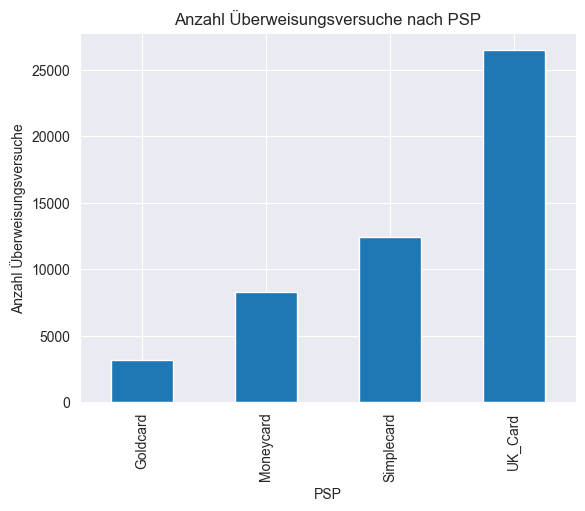

In [15]:
# Gruppierung der Daten
df_summarized = df_original.groupby('PSP')['index'].count()
# Erstellung des Diagramms
df_summarized.plot(kind='bar')
# Festlegung von Titel und Label
plt.ylabel('Anzahl Überweisungsversuche')
plt.title('Anzahl Überweisungsversuche nach PSP')

plt.show()

Darstellung der Anzahl erfolgreicher und nicht erfolgreicher Überweisungssvorgänge nach PSP.

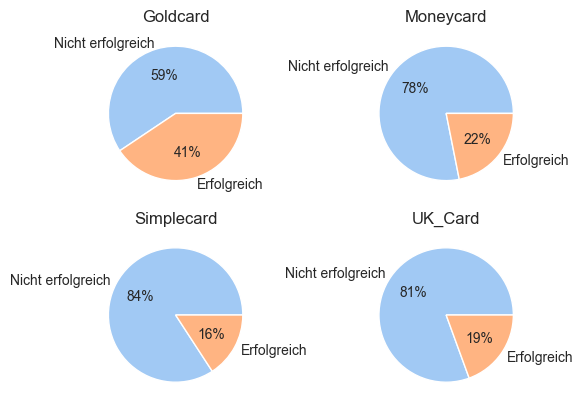

In [16]:
def create_success_plot_for_psp(ax, psp):
    # Gruppierung der Daten
    df_summarized = df_original[df_original['PSP'] == psp].groupby('success')['index'].count()
    # Festlegung von Titel, Label und Farben 
    labels = ['Nicht erfolgreich', 'Erfolgreich']
    colors = sns.color_palette('pastel')[0:2]
    ax.set_title(psp)
    # Erstellung des Diagramms
    ax.pie(df_summarized, labels=labels, colors=colors, autopct='%.0f%%')


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

# Erstellung der Diagramme für alle PSP
create_success_plot_for_psp(ax1, 'Goldcard')
create_success_plot_for_psp(ax2, 'Moneycard')
create_success_plot_for_psp(ax3, 'Simplecard')
create_success_plot_for_psp(ax4, 'UK_Card')

plt.show()

Vergleich der Erfolgsquote der PSP für Überweisungen anhand des Landes.

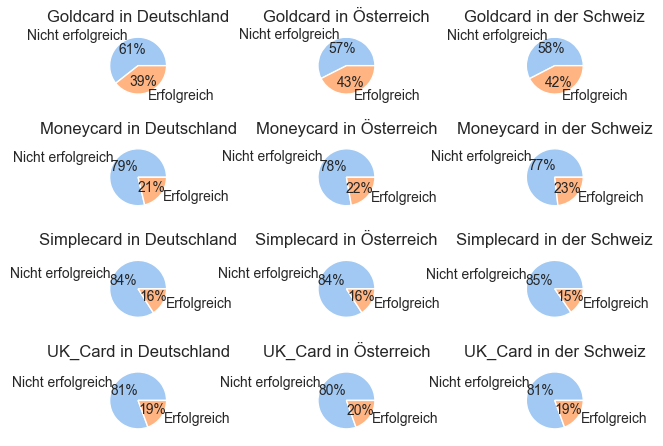

In [17]:
def create_country_plot_for_psp(ax_1, ax_2, ax_3, psp):
    # Gruppierung der Daten
    df_D_summarized = \
        df_original[(df_original['PSP'] == psp) & (df_original['country'] == 'Germany')].groupby('success')[
            'index'].count()
    df_A_summarized = \
        df_original[(df_original['PSP'] == psp) & (df_original['country'] == 'Austria')].groupby('success')[
            'index'].count()
    df_CH_summarized = \
        df_original[(df_original['PSP'] == psp) & (df_original['country'] == 'Switzerland')].groupby('success')[
            'index'].count()
    # Festlegung von Titel, Label, Layout und Farben
    labels = ['Nicht erfolgreich', 'Erfolgreich']
    colors = sns.color_palette('pastel')[0:2]
    fig.tight_layout()
    ax_1.set_title(psp + ' in Deutschland')
    ax_2.set_title(psp + ' in Österreich')
    ax_3.set_title(psp + ' in der Schweiz')
    # Erstellung des Diagramms
    ax_1.pie(df_D_summarized, labels=labels, colors=colors, autopct='%.0f%%')
    ax_2.pie(df_A_summarized, labels=labels, colors=colors, autopct='%.0f%%')
    ax_3.pie(df_CH_summarized, labels=labels, colors=colors, autopct='%.0f%%')


fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3)

# Erstellung der Diagramme für alle PSP
create_country_plot_for_psp(ax1, ax2, ax3, 'Goldcard')
create_country_plot_for_psp(ax4, ax5, ax6, 'Moneycard')
create_country_plot_for_psp(ax7, ax8, ax9, 'Simplecard')
create_country_plot_for_psp(ax10, ax11, ax12, 'UK_Card')

plt.show()

Vergleich der Erfolgsquote der PSP für Überweisungen anhand des Kartentyps.

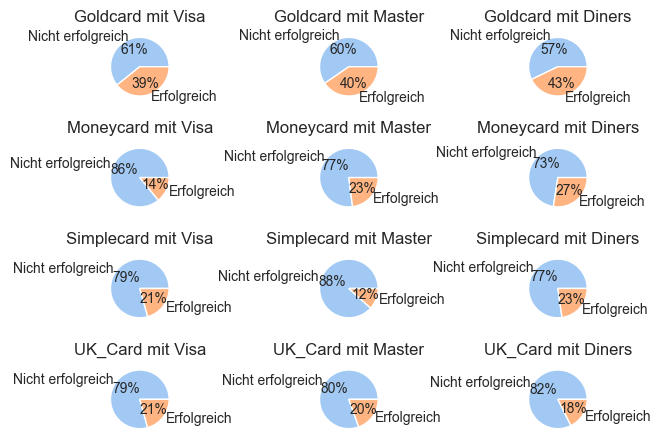

In [18]:
def create_card_plot_for_psp(ax_1, ax_2, ax_3, psp):
    # Gruppierung der Daten
    df_V_summarized = df_original[(df_original['PSP'] == psp) & (df_original['card'] == 'Visa')].groupby('success')[
        'index'].count()
    df_M_summarized = df_original[(df_original['PSP'] == psp) & (df_original['card'] == 'Master')].groupby('success')[
        'index'].count()
    df_D_summarized = df_original[(df_original['PSP'] == psp) & (df_original['card'] == 'Diners')].groupby('success')[
        'index'].count()
    # Festlegung von Titel, Label, Layout und Farben
    labels = ['Nicht erfolgreich', 'Erfolgreich']
    colors = sns.color_palette('pastel')[0:2]
    fig.tight_layout()
    ax_1.set_title(psp + ' mit Visa')
    ax_2.set_title(psp + ' mit Master')
    ax_3.set_title(psp + ' mit Diners')
    # Erstellung des Diagramms
    ax_1.pie(df_V_summarized, labels=labels, colors=colors, autopct='%.0f%%')
    ax_2.pie(df_M_summarized, labels=labels, colors=colors, autopct='%.0f%%')
    ax_3.pie(df_D_summarized, labels=labels, colors=colors, autopct='%.0f%%')


fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3)

# Erstellung der Diagramme für alle PSP
create_card_plot_for_psp(ax1, ax2, ax3, 'Goldcard')
create_card_plot_for_psp(ax4, ax5, ax6, 'Moneycard')
create_card_plot_for_psp(ax7, ax8, ax9, 'Simplecard')
create_card_plot_for_psp(ax10, ax11, ax12, 'UK_Card')

plt.show()

Vergleich der Erfolgsquote der PSP für Überweisungen anhand der Identifizierungsart.

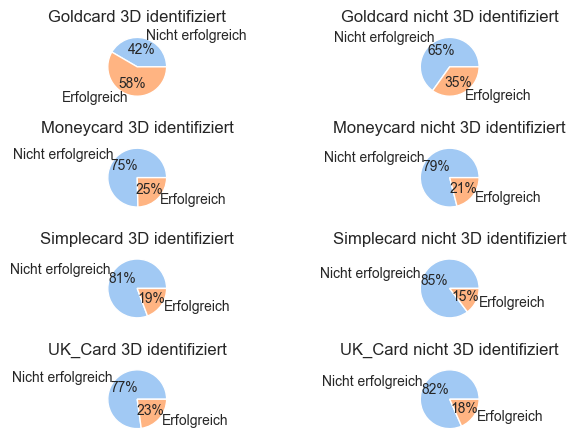

In [19]:
def create_ident_plot_for_psp(ax_1, ax_2, psp):
    # Gruppierung der Daten
    df_3D_summarized = df_original[(df_original['PSP'] == psp) & (df_original['3D_secured'] == 1)].groupby('success')[
        'index'].count()
    df_N3D_summarized = df_original[(df_original['PSP'] == psp) & (df_original['3D_secured'] == 0)].groupby('success')[
        'index'].count()
    # Festlegung von Titel, Label, Layout und Farben
    labels = ['Nicht erfolgreich', 'Erfolgreich']
    colors = sns.color_palette('pastel')[0:2]
    fig.tight_layout()
    ax_1.set_title(psp + ' 3D identifiziert')
    ax_2.set_title(psp + ' nicht 3D identifiziert')
    # Erstellung des Diagramms
    ax_1.pie(df_3D_summarized, labels=labels, colors=colors, autopct='%.0f%%')
    ax_2.pie(df_N3D_summarized, labels=labels, colors=colors, autopct='%.0f%%')


fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2)

# Erstellung der Diagramme für alle PSP
create_ident_plot_for_psp(ax1, ax2, 'Goldcard')
create_ident_plot_for_psp(ax3, ax4, 'Moneycard')
create_ident_plot_for_psp(ax5, ax6, 'Simplecard')
create_ident_plot_for_psp(ax7, ax8, 'UK_Card')

plt.show()

Überprüfen der Merkmalskorrelationen.

Korrelationen zwischen nominalen Merkmalen können mithilfe der Effektstärke nach Cramer's V gemessen werden.

Zur Messung der Beziehungen zwischen den nominalen Merkmalen und dem Umsatz wird der Umsatz in Klassen umgewandelt.
Somit kann auch hier die Effektstärke nach Cramer's V herangezogen werden.

Verwendete Literatur:

Raonier, R. (2022). *Generate Numerical Correlation and Nominal Association Plots using Python*. Medium. https://medium.com/the-researchers-guide/generate-numerical-correlation-and-nominal-association-plots-using-python-c8548aa4a663

Hemmerich, W. (2019). *Cramer's V*. StatistikGuru. https://statistikguru.de/lexikon/cramers-v.html

StackOverflow. (2018). *How to map numeric data into categories / bins in Pandas dataframe*. https://stackoverflow.com/questions/49382207/how-to-map-numeric-data-into-categories-bins-in-pandas-dataframe


In [20]:
# Zuordnung des Überweisungsbetrages zu einer Klasse
bins = [0, 100, 200, 300, 400, 500, 600, np.inf]
names = ['<100', '100-199', '200-299', '300-399', '400-499', '500-600', '>600']
df_categorical = df_original.copy()
df_categorical['amount_cat'] = pd.cut(df_original['amount'], bins, labels=names)

# Kategorisierung der nicht kategorischen Datentypen / Spalten
df_categorical = df_categorical.drop(columns=['tmsp']).astype({'3D_secured': "category", 'success': "category"})
df_categorical = df_categorical.apply(lambda x: x.astype("category") if x.dtype == "O" else x)

# Berechnen der Effektstärken
cramers_v = am.CramersV(df_categorical)
cv = cramers_v.fit().round(2)

# Ausgabe der Effektstärken
cv

,country,success,PSP,3D_secured,card,amount_cat
country,1.00,0.00,0.01,0.01,0.01,0.02
success,0.00,1.00,0.14,0.06,0.03,0.10
PSP,0.01,0.14,1.00,0.00,0.01,0.01
3D_secured,0.01,0.06,0.00,1.00,0.01,0.02
card,0.01,0.03,0.01,0.01,1.00,0.01
amount_cat,0.02,0.10,0.01,0.02,0.01,1.00


Die Effektstärken werden im nachfolgenden Diagramm visualisiert. 

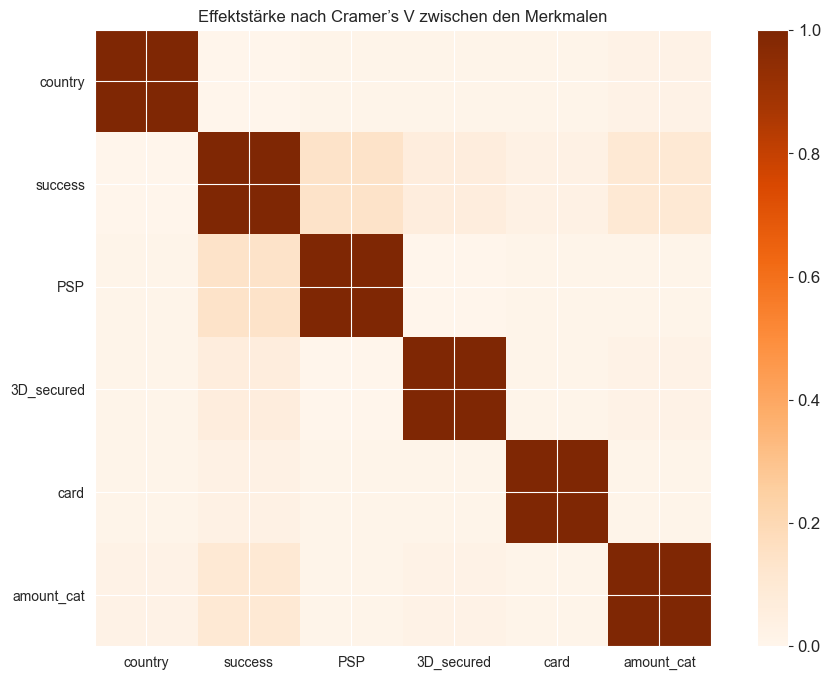

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))

# Erstellung des Diagramms
colors = ax.imshow(cv.values, interpolation='nearest', cmap='Oranges', vmin=0, vmax=1)

# Festlegung von Titel, Label und Farben
plt.title('Effektstärke nach Cramer’s V zwischen den Merkmalen')
ax.set_xticks(ticks=range(len(cv.columns)), labels=cv.columns)
ax.set_yticks(ticks=range(len(cv.columns)), labels=cv.columns)
fig.colorbar(colors).ax.tick_params(labelsize=12)

plt.show()

Begutachtung der Lage- und Streuungsmaße der einzelnen Variablen.

In [22]:
df_original.describe()

,index,amount,success,3D_secured
count,50410.000000,50410.000000,50410.000000,50410.000000
mean,25204.500000,202.395715,0.202896,0.238266
std,14552.257872,96.274730,0.402160,0.426027
min,0.000000,6.000000,0.000000,0.000000
25%,12602.250000,133.000000,0.000000,0.000000
50%,25204.500000,201.000000,0.000000,0.000000
75%,37806.750000,269.000000,0.000000,0.000000
max,50409.000000,630.000000,1.000000,1.000000


## Abschnitt 2: Prüfung der Datenqualität
Nachfolgend wird die Qualität der bereitgestellen Transaktionsdaten untersucht.

In [23]:
df_original.head()

,index,tmsp,country,amount,success,PSP,3D_secured,card
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


Es wird für den kompletten Datensatz überprüft, ob Null-Werte existieren.

In [24]:
df_original.isnull().values.any()

False

Es werden das Schema und die Datentypen des Datensatzes untersucht.

In [25]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       50410 non-null  int64 
 1   tmsp        50410 non-null  object
 2   country     50410 non-null  object
 3   amount      50410 non-null  int64 
 4   success     50410 non-null  int64 
 5   PSP         50410 non-null  object
 6   3D_secured  50410 non-null  int64 
 7   card        50410 non-null  object
dtypes: int64(4), object(4)
memory usage: 3.1+ MB


Es werden die Wertebereiche und Merkmalsausprägungen im Datensatz begutachtet.

Zunächst wird die Anzahl an unterschiedlichen Ausprägungen für jedes Merkmal betrachtet.

In [26]:
df_original.nunique()

index         50410
tmsp          50121
country           3
amount          517
success           2
PSP               4
3D_secured        2
card              3
dtype: int64

Nun werden alle Merkmalsausprägungen für jede Spalte ausgegeben.

In [27]:
for column in df_original.drop(columns=['index']).columns:
    print("Merkmalsausprägungen für", column, df_original[column].unique(), '\n')

Merkmalsausprägungen für tmsp ['2019-01-01 00:01:11' '2019-01-01 00:01:17' '2019-01-01 00:02:49' ...
 '2019-02-28 23:47:04' '2019-02-28 23:47:36' '2019-02-28 23:48:19'] 

Merkmalsausprägungen für country ['Germany' 'Austria' 'Switzerland'] 

Merkmalsausprägungen für amount [ 89 238 124 282 117 174 232 268 205 111 277 137 148 394  84  34 324 251
 100 221 340 257 193  36 146 192  14 175 270 256 310 239  37  56 105 228
 322 367 190 186 121 274 264 132 279 104 184 258 209 260 383 109 161 127
 233 129 243 131 225 246 126  82 329 335 173 222 181  85  62 291 107  78
  22 164 203 113 379 224 242  45 158 140  13 197 215 151 208 116 263 136
 211 180 125 247 376 162 355 135 188  38 144  23 202 212 273 230 141 293
 336 163 350 374 176 218  53 267 255 216 450 301 271 183 198  19 214 147
 368 249  72 315 199 142 262  65  44 169 269 201 118 229 240 339 154 156
  86 250 390 297 308 223 191 170 488 304 219 444 189 317 200 172 206  69
 220 428 185 235 153 399 296 312 283  74  49 165 307 306 309 252 353 

Die Daten in der Zeitspalte werden auf die Gültigkeit des Formates überprüft.

In [28]:
df_time = df_original.copy()
try:
    pd.to_datetime(df_time['tmsp'], format='%Y-%m-%d %H:%M:%S', errors='raise')
    print("Keine Formatfehler für Spalte tmsp")
except ValueError:
    print("Formatfehler für Spalte tmsp")

Keine Formatfehler für Spalte tmsp


Es soll ein Überblick über die statistischen Eigenschaften der numerischen Daten gegeben werden.

In [29]:
df_original.drop(columns=['index']).describe()

,amount,success,3D_secured
count,50410.000000,50410.000000,50410.000000
mean,202.395715,0.202896,0.238266
std,96.274730,0.402160,0.426027
min,6.000000,0.000000,0.000000
25%,133.000000,0.000000,0.000000
50%,201.000000,0.000000,0.000000
75%,269.000000,0.000000,0.000000
max,630.000000,1.000000,1.000000


Die Verteilung der Werte in der Spalte Umsatz wird nachfolgend genauer untersucht.

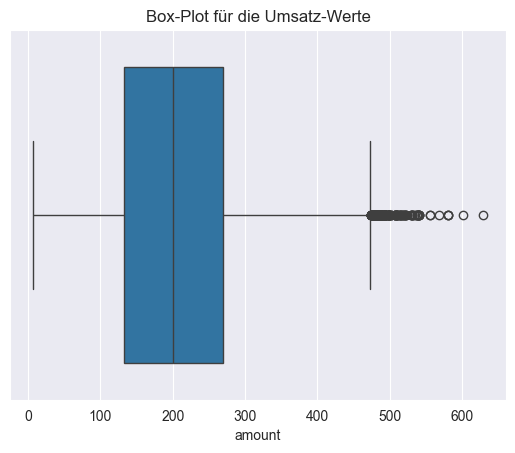

In [30]:
# Erstellung des Diagramms
sns.boxplot(x=df_original['amount'])
# Festlegen des Titels
plt.title('Box-Plot für die Umsatz-Werte')

plt.show()

## Abschnitt 3: Datenaggregation / Umwandeln der Zielvariablen in eine Wahrscheinlichkeit
Im folgenden Abschnitt werden die Überweisungen zu Vorgängen aggregiert, um somit eine Erfolgswahrscheinlichkeit zu bestimmen.

Zunächst sollen zusammengehörige Überweisungsversuche gefunden werden. Hierfür wird der Zeitraum, der Betrag und das Land der Überweisungen verglichen.

In [31]:
df_grouped = df_original
# Einfügen der Hilfsmerkmals group_id
df_grouped['group_id'] = 0

count_group_id = 0

# Iterieren über alle Überweisungsversuche
for index, row in df_original.iterrows():

    if index != 0:
        # Berechnung der Zeitdifferenz zweier Überweisungsversuche
        check_date = pd.to_datetime(last_row['tmsp'], format='%Y-%m-%d %H:%M:%S')
        current_date = pd.to_datetime(row['tmsp'], format='%Y-%m-%d %H:%M:%S')
        time_delta = (current_date - check_date).seconds / 60

        # Prüfen zweier Überweisungsversuche auf Zusammengehörigkeit
        if last_row['country'] == row['country'] and last_row['amount'] == row['amount'] and (time_delta <= 1):
            df_grouped['group_id'][index] = count_group_id

        else:
            count_group_id = count_group_id + 1

    df_grouped['group_id'][index] = count_group_id
    last_row = row

df_grouped.head()

,index,tmsp,country,amount,success,PSP,3D_secured,card,group_id
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,1
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,1
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,2


Es wird eine ID erzeugt, welche Überweisungsgruppen nach PSP unterteilt.

In [32]:
df_grouped['group_psp_key'] = df_grouped['group_id'].astype(str) + df_grouped['PSP']
df_grouped.head()

,index,tmsp,country,amount,success,PSP,3D_secured,card,group_id,group_psp_key
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0,0UK_Card
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0,0UK_Card
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,1,1UK_Card
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,1,1UK_Card
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,2,2Simplecard


Für jede Überweisungsgruppe soll herausgefunden werden, ob ein Erfolg verbucht werden konnte.

In [33]:
df_helper_sum = df_grouped[['group_psp_key', 'success']].groupby(by=["group_psp_key"]).sum()
df_helper_sum.rename(columns={'success': 'success_sum'}, inplace=True)
df_helper_sum.head()

,success_sum
group_psp_key,
0UK_Card,1
10000Simplecard,0
10000UK_Card,0
10001Moneycard,0
10001Simplecard,0


Für jede Überweisungsgruppe soll herausgefunden werden, wie viele Versuche ausgeführt wurden.

In [34]:
df_helper_count = df_grouped[['group_psp_key', 'index']].groupby(by=["group_psp_key"]).count()
df_helper_count.rename(columns={'index': 'index_count'}, inplace=True)
df_helper_count.head()

,index_count
group_psp_key,
0UK_Card,2
10000Simplecard,1
10000UK_Card,1
10001Moneycard,1
10001Simplecard,1


Die Untersuchungsergebnisse werden an die Ursprungstabelle angefügt.

In [35]:
df_aggregated = pd.merge(df_grouped, df_helper_sum, left_on='group_psp_key', right_on='group_psp_key')
df_aggregated = pd.merge(df_aggregated, df_helper_count, left_on='group_psp_key', right_on='group_psp_key')
df_aggregated.head()

,index,tmsp,country,amount,success,PSP,3D_secured,card,group_id,group_psp_key,success_sum,index_count
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0,0UK_Card,1,2
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0,0UK_Card,1,2
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,1,1UK_Card,1,2
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,1,1UK_Card,1,2
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,2,2Simplecard,0,1


Nun wird die Erfolgsquote für jeden Versuch ermittelt.

In [36]:
df_aggregated['success_rate'] = df_aggregated['success_sum'] / df_aggregated['index_count']
df_aggregated.head()

,index,tmsp,country,amount,success,PSP,3D_secured,card,group_id,group_psp_key,success_sum,index_count,success_rate
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0,0UK_Card,1,2,0.5
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0,0UK_Card,1,2,0.5
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,1,1UK_Card,1,2,0.5
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,1,1UK_Card,1,2,0.5
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,2,2Simplecard,0,1,0.0


Es soll ein Überblick über die generierten Daten gewonnen werden.

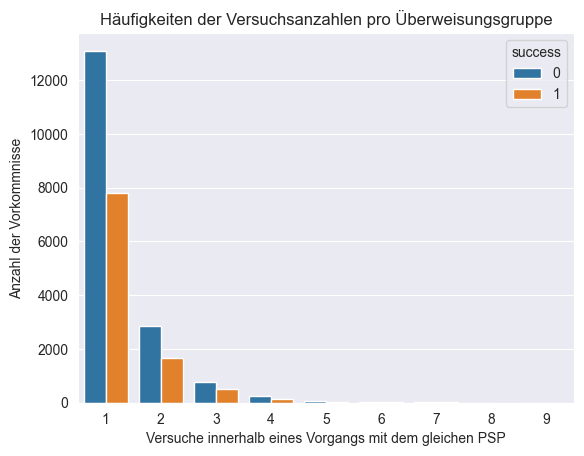

In [37]:
# Erstellung des Diagramms
sns.countplot(data=df_aggregated.sort_values('success', ascending=False).drop_duplicates(['group_id']),
              x='index_count',
              hue='success')
# Festlegung von Titel und Label
plt.xlabel('Versuche innerhalb eines Vorgangs mit dem gleichen PSP')
plt.ylabel('Anzahl der Vorkommnisse')
plt.title('Häufigkeiten der Versuchsanzahlen pro Überweisungsgruppe')

plt.show()

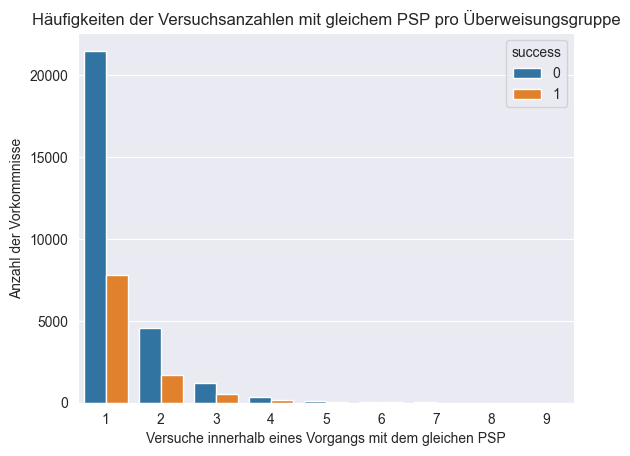

In [38]:
# Erstellung des Diagramms
sns.countplot(data=df_aggregated.sort_values('success', ascending=False).drop_duplicates(['group_psp_key']),
              x='index_count',
              hue='success')
# Festlegung von Titel und Label
plt.xlabel('Versuche innerhalb eines Vorgangs mit dem gleichen PSP')
plt.ylabel('Anzahl der Vorkommnisse')
plt.title('Häufigkeiten der Versuchsanzahlen mit gleichem PSP pro Überweisungsgruppe')

plt.show()

In [39]:
print("Anzahl Überweisungsgruppen: ", df_aggregated.drop_duplicates(['group_id']).count().iloc[0])
print("Anzahl Überweisungsgruppen (mit gleichem PSP): ",
      df_aggregated.drop_duplicates(['group_psp_key']).count().iloc[0])

Anzahl Überweisungsgruppen:  27337
Anzahl Überweisungsgruppen (mit gleichem PSP):  38033


Die Hilfsspalten können nun wieder entfernt werden. 

In [40]:
def drop_helper_columns(df):
    df = df.drop(columns=['success_sum', 'group_psp_key', 'group_id'])
    return df


df_aggregated = drop_helper_columns(df_aggregated)
df_aggregated.head()

,index,tmsp,country,amount,success,PSP,3D_secured,card,index_count,success_rate
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,2,0.5
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,2,0.5
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,2,0.5
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,2,0.5
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,1,0.0


Für Datensätze, welche nicht als erfolgreich gekennzeichnet sind, kann nur schwer ein sinnvoller Rückschluss auf die Erfolgsquote gezogen werden.
Hier wurden unter Umständen zu wenige Versuche unternommen, um einen Erfolg und somit eine Erfolgsquote festzuhalten.
Einige der erfolgreichen Transaktionen gelingen nicht im ersten Versuch (siehe vorheriges Diagramm und Zusatzinformationen). Somit wird festgelegt, dass erst ab zwei erfolglosen Versuchen bei Nichterfolgen eine Erfolgsquote von 0 festgehalten wird. Hierdurch werden 0%-Erfolgsquoten aufgrund zu weniger Versuche vermieden. Dieses Vorgehen führt zu geringfügig weniger Daten, allerdings auch zu einer verbesserten Datenqualität.

Danach wird die ursprüngliche Erfolgsspalte nun ebenso entfernt, da mit der Erfolgsrate nun eine neue Zielvariable eingefügt wurde.

In [41]:
df_aggregated = df_aggregated[
    (df_aggregated['success_rate'] > 0) | ((df_aggregated['success_rate'] == 0) & (df_aggregated['index_count'] > 1))]
df_aggregated = df_aggregated.drop(columns=['success', 'index_count'])
df_aggregated

,index,tmsp,country,amount,PSP,3D_secured,card,success_rate
0,0,2019-01-01 00:01:11,Germany,89,UK_Card,0,Visa,0.5
1,1,2019-01-01 00:01:17,Germany,89,UK_Card,0,Visa,0.5
2,2,2019-01-01 00:02:49,Germany,238,UK_Card,1,Diners,0.5
3,3,2019-01-01 00:03:13,Germany,238,UK_Card,1,Diners,0.5
7,7,2019-01-01 00:08:46,Germany,117,UK_Card,0,Master,1.0
...,...,...,...,...,...,...,...,...
50405,50405,2019-02-28 23:45:39,Switzerland,415,UK_Card,0,Visa,0.0
50406,50406,2019-02-28 23:46:48,Austria,91,UK_Card,0,Master,0.0
50407,50407,2019-02-28 23:47:04,Austria,91,UK_Card,0,Master,0.0
50408,50408,2019-02-28 23:47:36,Austria,91,UK_Card,0,Master,0.0


## Abschnitt 4: Generierung von Merkmalen / Feature Engineering
Im nächsten Abschnitt werden weitere Merkmale generiert, welche für das maschinelle Lernmodell hilfreich sein könnten.

Zunächst werden die Zeitinformationen in ein Datetime-Format umgewandelt.

In [42]:
def add_timestamp(df):
    df['tmsp'] = pd.to_datetime(df['tmsp'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    return df


df_enriched = add_timestamp(df_aggregated)
df_enriched.head()

,index,tmsp,country,amount,PSP,3D_secured,card,success_rate
0,0,2019-01-01 00:01:11,Germany,89,UK_Card,0,Visa,0.5
1,1,2019-01-01 00:01:17,Germany,89,UK_Card,0,Visa,0.5
2,2,2019-01-01 00:02:49,Germany,238,UK_Card,1,Diners,0.5
3,3,2019-01-01 00:03:13,Germany,238,UK_Card,1,Diners,0.5
7,7,2019-01-01 00:08:46,Germany,117,UK_Card,0,Master,1.0


Nun werden separate Spalten für die Zeitinformationen erstellt.

In [43]:
def add_time_columns(df):
    df['year'] = df['tmsp'].dt.year
    df['month'] = df['tmsp'].dt.month
    df['day'] = df['tmsp'].dt.day
    df['hour'] = df['tmsp'].dt.hour
    df['minute'] = df['tmsp'].dt.minute
    df['day_of_week'] = df['tmsp'].dt.dayofweek
    return df


df_enriched = add_time_columns(df_enriched)
df_enriched.head()

,index,tmsp,country,amount,PSP,3D_secured,card,success_rate,year,month,day,hour,minute,day_of_week
0,0,2019-01-01 00:01:11,Germany,89,UK_Card,0,Visa,0.5,2019,1,1,0,1,1
1,1,2019-01-01 00:01:17,Germany,89,UK_Card,0,Visa,0.5,2019,1,1,0,1,1
2,2,2019-01-01 00:02:49,Germany,238,UK_Card,1,Diners,0.5,2019,1,1,0,2,1
3,3,2019-01-01 00:03:13,Germany,238,UK_Card,1,Diners,0.5,2019,1,1,0,3,1
7,7,2019-01-01 00:08:46,Germany,117,UK_Card,0,Master,1.0,2019,1,1,0,8,1


Einteilen der Stunden in Tagesabschnitte.

In [44]:
def add_day_part(df):
    def apply_part(hour):
        if hour in [6, 7, 8, 9, 10]:
            return "morning"
        elif hour in [11, 12, 13]:
            return "noon"
        elif hour in [14, 15, 16]:
            return "afternoon"
        elif hour in [17, 18, 19, 20, 21]:
            return "evening"
        elif hour in [22, 23, 24, 0, 1, 2, 3, 4, 5]:
            return "night"

    df['day_part'] = df['hour'].apply(apply_part)
    return df


df_enriched = add_day_part(df_enriched)
df_enriched.head()

,index,tmsp,country,amount,PSP,3D_secured,card,success_rate,year,month,day,hour,minute,day_of_week,day_part
0,0,2019-01-01 00:01:11,Germany,89,UK_Card,0,Visa,0.5,2019,1,1,0,1,1,night
1,1,2019-01-01 00:01:17,Germany,89,UK_Card,0,Visa,0.5,2019,1,1,0,1,1,night
2,2,2019-01-01 00:02:49,Germany,238,UK_Card,1,Diners,0.5,2019,1,1,0,2,1,night
3,3,2019-01-01 00:03:13,Germany,238,UK_Card,1,Diners,0.5,2019,1,1,0,3,1,night
7,7,2019-01-01 00:08:46,Germany,117,UK_Card,0,Master,1.0,2019,1,1,0,8,1,night


Einteilen der Tage in Monatsabschnitte.

In [45]:
def add_month_part(df):
    def apply_part(day):
        if day in range(0, 10):
            return "start"
        elif day in range(10, 20):
            return "mid"
        elif day in range(20, 32):
            return "end"

    df['month_part'] = df['day'].apply(apply_part)
    return df


df_enriched = add_month_part(df_enriched)
df_enriched.head()

,index,tmsp,country,amount,PSP,3D_secured,card,success_rate,year,month,day,hour,minute,day_of_week,day_part,month_part
0,0,2019-01-01 00:01:11,Germany,89,UK_Card,0,Visa,0.5,2019,1,1,0,1,1,night,start
1,1,2019-01-01 00:01:17,Germany,89,UK_Card,0,Visa,0.5,2019,1,1,0,1,1,night,start
2,2,2019-01-01 00:02:49,Germany,238,UK_Card,1,Diners,0.5,2019,1,1,0,2,1,night,start
3,3,2019-01-01 00:03:13,Germany,238,UK_Card,1,Diners,0.5,2019,1,1,0,3,1,night,start
7,7,2019-01-01 00:08:46,Germany,117,UK_Card,0,Master,1.0,2019,1,1,0,8,1,night,start


Hinzufügen der Wochenende-Information als Merkmal.

In [46]:
def add_weekend(df):
    df['weekend'] = np.where(df['day_of_week'].isin([5, 6]), 1, 0)
    return df


df_enriched = add_weekend(df_enriched)
df_enriched.head()

,index,tmsp,country,amount,PSP,3D_secured,card,success_rate,year,month,day,hour,minute,day_of_week,day_part,month_part,weekend
0,0,2019-01-01 00:01:11,Germany,89,UK_Card,0,Visa,0.5,2019,1,1,0,1,1,night,start,0
1,1,2019-01-01 00:01:17,Germany,89,UK_Card,0,Visa,0.5,2019,1,1,0,1,1,night,start,0
2,2,2019-01-01 00:02:49,Germany,238,UK_Card,1,Diners,0.5,2019,1,1,0,2,1,night,start,0
3,3,2019-01-01 00:03:13,Germany,238,UK_Card,1,Diners,0.5,2019,1,1,0,3,1,night,start,0
7,7,2019-01-01 00:08:46,Germany,117,UK_Card,0,Master,1.0,2019,1,1,0,8,1,night,start,0


Hinzufügen eines Feiertag-Merkmals.
Die Feiertage für Deutschland werden über eine API abgerufen.

In [47]:
def add_holidays(df, print_holidays=True):
    holidays = None

    def apply_holiday(timestamp):
        if timestamp.date() in holidays.values():
            return 1
        return 0

    # Laden der Feiertage über eine API
    configuration = feiertage.Configuration(host="https://feiertage-api.de/api")

    with feiertage.ApiClient(configuration) as client:
        api_instance = default_api.DefaultApi(client)
        try:
            holidays = api_instance.get_feiertage("2019", nur_daten=1)
            df['holiday'] = df['tmsp'].apply(apply_holiday)
        except feiertage.ApiException as e:
            print("Fehler beim Einlesen der Feiertage: %s\n" % e)
    if print_holidays:
        print(holidays)

    return df


df_enriched = add_holidays(df_enriched)
df_enriched.head()

{'Neujahrstag': datetime.date(2019, 1, 1), 'Heilige Drei Könige': datetime.date(2019, 1, 6), 'Frauentag': datetime.date(2019, 3, 8), 'Gründonnerstag': datetime.date(2019, 4, 18), 'Karfreitag': datetime.date(2019, 4, 19), 'Ostersonntag': datetime.date(2019, 4, 21), 'Ostermontag': datetime.date(2019, 4, 22), 'Tag der Arbeit': datetime.date(2019, 5, 1), 'Christi Himmelfahrt': datetime.date(2019, 5, 30), 'Pfingstsonntag': datetime.date(2019, 6, 9), 'Pfingstmontag': datetime.date(2019, 6, 10), 'Fronleichnam': datetime.date(2019, 6, 20), 'Augsburger Friedensfest': datetime.date(2019, 8, 8), 'Mariä Himmelfahrt': datetime.date(2019, 8, 15), 'Weltkindertag': datetime.date(2019, 9, 20), 'Tag der Deutschen Einheit': datetime.date(2019, 10, 3), 'Reformationstag': datetime.date(2019, 10, 31), 'Allerheiligen': datetime.date(2019, 11, 1), 'Buß- und Bettag': datetime.date(2019, 11, 20), '1. Weihnachtstag': datetime.date(2019, 12, 25), '2. Weihnachtstag': datetime.date(2019, 12, 26)}


,index,tmsp,country,amount,PSP,3D_secured,card,success_rate,year,month,day,hour,minute,day_of_week,day_part,month_part,weekend,holiday
0,0,2019-01-01 00:01:11,Germany,89,UK_Card,0,Visa,0.5,2019,1,1,0,1,1,night,start,0,1
1,1,2019-01-01 00:01:17,Germany,89,UK_Card,0,Visa,0.5,2019,1,1,0,1,1,night,start,0,1
2,2,2019-01-01 00:02:49,Germany,238,UK_Card,1,Diners,0.5,2019,1,1,0,2,1,night,start,0,1
3,3,2019-01-01 00:03:13,Germany,238,UK_Card,1,Diners,0.5,2019,1,1,0,3,1,night,start,0,1
7,7,2019-01-01 00:08:46,Germany,117,UK_Card,0,Master,1.0,2019,1,1,0,8,1,night,start,0,1


Kennzeichnen von Tagen als Werktage.

In [48]:
def add_working_day(df):
    df['working_day'] = np.where((df['weekend'] == 1) | (df['holiday'] == 1), 0, 1)
    return df


df_enriched = add_working_day(df_enriched)
df_enriched.head()

,index,tmsp,country,amount,PSP,3D_secured,card,success_rate,year,month,day,hour,minute,day_of_week,day_part,month_part,weekend,holiday,working_day
0,0,2019-01-01 00:01:11,Germany,89,UK_Card,0,Visa,0.5,2019,1,1,0,1,1,night,start,0,1,0
1,1,2019-01-01 00:01:17,Germany,89,UK_Card,0,Visa,0.5,2019,1,1,0,1,1,night,start,0,1,0
2,2,2019-01-01 00:02:49,Germany,238,UK_Card,1,Diners,0.5,2019,1,1,0,2,1,night,start,0,1,0
3,3,2019-01-01 00:03:13,Germany,238,UK_Card,1,Diners,0.5,2019,1,1,0,3,1,night,start,0,1,0
7,7,2019-01-01 00:08:46,Germany,117,UK_Card,0,Master,1.0,2019,1,1,0,8,1,night,start,0,1,0


Die Umsätze werden kategorisiert, um die Anzahl an Merkmalsausprägungen zu verringern und die Daten einfacher kategorisieren zu können.

In [49]:
def add_amount_categories(df):
    # Bilden der Kategorien
    bins = [0, 100, 200, 300, 400, 500, 600, np.inf]
    names = [0, 1, 2, 3, 4, 5, 6]

    # Umwandeln der Umsätze in Umsatz-Kategorien
    df['amount_categories'] = pd.cut(df['amount'], bins, labels=names)
    df = df.astype({'amount_categories': 'int32'})
    return df


df_enriched = add_amount_categories(df_enriched)
df_enriched.head()

,index,tmsp,country,amount,PSP,3D_secured,card,success_rate,year,month,day,hour,minute,day_of_week,day_part,month_part,weekend,holiday,working_day,amount_categories
0,0,2019-01-01 00:01:11,Germany,89,UK_Card,0,Visa,0.5,2019,1,1,0,1,1,night,start,0,1,0,0
1,1,2019-01-01 00:01:17,Germany,89,UK_Card,0,Visa,0.5,2019,1,1,0,1,1,night,start,0,1,0,0
2,2,2019-01-01 00:02:49,Germany,238,UK_Card,1,Diners,0.5,2019,1,1,0,2,1,night,start,0,1,0,2
3,3,2019-01-01 00:03:13,Germany,238,UK_Card,1,Diners,0.5,2019,1,1,0,3,1,night,start,0,1,0,2
7,7,2019-01-01 00:08:46,Germany,117,UK_Card,0,Master,1.0,2019,1,1,0,8,1,night,start,0,1,0,1


Durchführen des One-Hot-Encodings für die kategorischen Merkmale.

In [50]:
def add_one_hot_encoding(df):
    df_enc = pd.get_dummies(df, columns=['country', 'PSP', 'card', 'day_of_week', 'day_part', 'month_part'])
    return df_enc


df_encoded = add_one_hot_encoding(df_enriched)
df_encoded.head()

,index,tmsp,amount,3D_secured,success_rate,year,month,day,hour,minute,...,day_of_week_5,day_of_week_6,day_part_afternoon,day_part_evening,day_part_morning,day_part_night,day_part_noon,month_part_end,month_part_mid,month_part_start
0,0,2019-01-01 00:01:11,89,0,0.5,2019,1,1,0,1,...,False,False,False,False,False,True,False,False,False,True
1,1,2019-01-01 00:01:17,89,0,0.5,2019,1,1,0,1,...,False,False,False,False,False,True,False,False,False,True
2,2,2019-01-01 00:02:49,238,1,0.5,2019,1,1,0,2,...,False,False,False,False,False,True,False,False,False,True
3,3,2019-01-01 00:03:13,238,1,0.5,2019,1,1,0,3,...,False,False,False,False,False,True,False,False,False,True
7,7,2019-01-01 00:08:46,117,0,1.0,2019,1,1,0,8,...,False,False,False,False,False,True,False,False,False,True


Die redundanten Merkmale und IDs können bzw. sollten aus dem Datensatz entfernt werden.
Dies beinhaltet auch solche Merkmale, welche in neuen Spalten kategorisiert wurden.

Die Merkmale Jahr und Monat sollten in jedem Fall entfernt werden, da nicht alle möglichen Merkmalsausprägungen in den vorhandenen Daten repräsentiert sind. 

In [51]:
def remove_redundant_columns(df):
    return df.drop(columns=['index', 'amount', 'tmsp', 'year', 'month', 'day', 'minute'])


df_reduced = remove_redundant_columns(df_encoded)
df_reduced.head()

,3D_secured,success_rate,hour,weekend,holiday,working_day,amount_categories,country_Austria,country_Germany,country_Switzerland,...,day_of_week_5,day_of_week_6,day_part_afternoon,day_part_evening,day_part_morning,day_part_night,day_part_noon,month_part_end,month_part_mid,month_part_start
0,0,0.5,0,0,1,0,0,False,True,False,...,False,False,False,False,False,True,False,False,False,True
1,0,0.5,0,0,1,0,0,False,True,False,...,False,False,False,False,False,True,False,False,False,True
2,1,0.5,0,0,1,0,2,False,True,False,...,False,False,False,False,False,True,False,False,False,True
3,1,0.5,0,0,1,0,2,False,True,False,...,False,False,False,False,False,True,False,False,False,True
7,0,1.0,0,0,1,0,1,False,True,False,...,False,False,False,False,False,True,False,False,False,True


Der Datensatz sieht nach dem Feature Engineering damit wie folgt aus.

In [52]:
df_reduced.head()

,3D_secured,success_rate,hour,weekend,holiday,working_day,amount_categories,country_Austria,country_Germany,country_Switzerland,...,day_of_week_5,day_of_week_6,day_part_afternoon,day_part_evening,day_part_morning,day_part_night,day_part_noon,month_part_end,month_part_mid,month_part_start
0,0,0.5,0,0,1,0,0,False,True,False,...,False,False,False,False,False,True,False,False,False,True
1,0,0.5,0,0,1,0,0,False,True,False,...,False,False,False,False,False,True,False,False,False,True
2,1,0.5,0,0,1,0,2,False,True,False,...,False,False,False,False,False,True,False,False,False,True
3,1,0.5,0,0,1,0,2,False,True,False,...,False,False,False,False,False,True,False,False,False,True
7,0,1.0,0,0,1,0,1,False,True,False,...,False,False,False,False,False,True,False,False,False,True


## Abschnitt 5: Entwicklung des Baseline-Modells
In diesem Abschnitt wird mit dem DecisionTreeRegressor ein einfaches Baseline-Modell entwickelt, dessen Metriken später als Vergleichswerte herangezogen werden können. 

Zunächst werden 15 zufällige Spalten aus den Daten genutzt und damit die Trainings- und Testmenge aufgebaut. Es wird Oversampling genutzt, um unterrepräsentierte Erfolgswahrscheinlichkeiten auszugleichen.

In [53]:
# Auswahl der 15 zufälligen Spalten
X = df_reduced.drop(columns=['success_rate']).sample(axis='columns', n=15, random_state=0)
y = df_reduced['success_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Nutzen der Versuchsanzahl (1/Erfolgsquote) für das Oversampling
oversampler = RandomOverSampler(random_state=42)

y_temp = np.where(y_train == 0, 0, 1 / y_train).astype(int)
X_train_oversample, y_train_oversample = oversampler.fit_resample(X_train, y_temp)
y_train_oversample = np.where(y_train_oversample == 0.0, 0, 1 / y_train_oversample).astype(float)

X_train_oversample.head()

,weekend,month_part_mid,card_Diners,PSP_Moneycard,day_part_noon,day_part_morning,day_of_week_6,PSP_Simplecard,day_of_week_1,day_part_afternoon,amount_categories,day_of_week_0,country_Switzerland,card_Master,day_part_evening
0,1,True,False,False,True,False,True,False,False,False,0,False,False,True,False
1,0,False,False,False,False,False,False,False,False,True,0,False,False,False,False
2,0,True,False,False,False,False,False,False,False,False,1,False,False,True,True
3,0,False,True,False,False,True,False,False,False,False,1,False,False,False,False
4,0,True,False,False,False,False,False,False,True,False,1,False,False,False,False


Nun wird ein einfacher DecisionTree als Baseline-Regressionsmodell genutzt.
In der Ergebnistabelle der Testdaten sind sowohl die Erfolgsquotenvorhersagen als auch die tatsächlichen Erfolgsquoten eingetragen.

In [54]:
# Trainieren des Modells
baselineRegressor = DecisionTreeRegressor()
baselineRegressor.fit(X_train_oversample, y_train_oversample)

# Vorhersagen mithilfe des Modells
predictions = baselineRegressor.predict(X_test)

# Zusammenführen der Testergebnisse
test_results = pd.DataFrame(X_test)
test_results['actual'] = y_test
test_results['predicted'] = predictions

test_results.head()

,weekend,month_part_mid,card_Diners,PSP_Moneycard,day_part_noon,day_part_morning,day_of_week_6,PSP_Simplecard,day_of_week_1,day_part_afternoon,amount_categories,day_of_week_0,country_Switzerland,card_Master,day_part_evening,actual,predicted
42344,0,True,False,False,False,False,False,True,False,False,2,True,False,False,True,1.0,1.00000
4856,1,False,False,False,False,True,False,False,False,False,0,False,True,False,False,1.0,1.00000
59,0,False,False,False,False,False,False,False,True,False,1,False,False,True,False,0.5,0.41608
17004,1,True,False,False,False,False,False,False,False,False,2,False,False,False,True,0.0,0.31250
17920,0,False,False,False,False,True,False,False,False,False,4,True,False,True,False,0.0,0.75000


Die Abweichungen der Wahrscheinlichkeitsvorhersagen und der tatsächlichen Erfolgswahrscheinlichkeiten werden nun analysiert.

In [55]:
print('Mean squared Error: ', metrics.mean_squared_error(predictions, y_test))
print('Mean absolute Error: ', metrics.mean_absolute_error(predictions, y_test))
print("-----------------------------------------------------------------------------------------")

Mean squared Error:  0.1810928409250197
Mean absolute Error:  0.34807932975008377
-----------------------------------------------------------------------------------------


## Abschnitt 6: Auswahl von Merkmalen / Feature Selection
Im nächsten Abschnitt wird eine Lernmodell-unabhängige Auswahl der Merkmale vorgenommen.

Mithilfe des univariaten, linearen Regressionstests, basierend auf einem F-Test, können die wichtigsten Features unabhängig von einem Lernmodell ermittelt werden.

In einem ersten Schritt wird die Relevanz der einzelnen Features bezüglich der Vorhersage der Erfolgswahrscheinlichkeit ausgegeben. Anschließend werden die besten 10 Features gelistet.

Feature 3D_secured 110.7672556898034
Feature hour 5.351939255327268
Feature weekend 154.22218747207307
Feature holiday 0.1178020639002488
Feature working_day 122.7742593747473
Feature amount_categories 403.5926858450516
Feature country_Austria 0.9936559997048842
Feature country_Germany 4.335418096177042
Feature country_Switzerland 2.4078892617112886
Feature PSP_Goldcard 2819.309391426633
Feature PSP_Moneycard 879.4276816584423
Feature PSP_Simplecard 66.5331532258557
Feature PSP_UK_Card 2666.0255790053034
Feature card_Diners 27.215696865912257
Feature card_Master 39.02616561912039
Feature card_Visa 5.76474999633816
Feature day_of_week_0 2.8125752062980065
Feature day_of_week_1 49.11723505586799
Feature day_of_week_2 7.685591216402956
Feature day_of_week_3 0.6339192602727306
Feature day_of_week_4 2.3339863551896065
Feature day_of_week_5 53.84316406014166
Feature day_of_week_6 84.58039542153841
Feature day_part_afternoon 15.570347136319672
Feature day_part_evening 1.7052281149778732
Featu

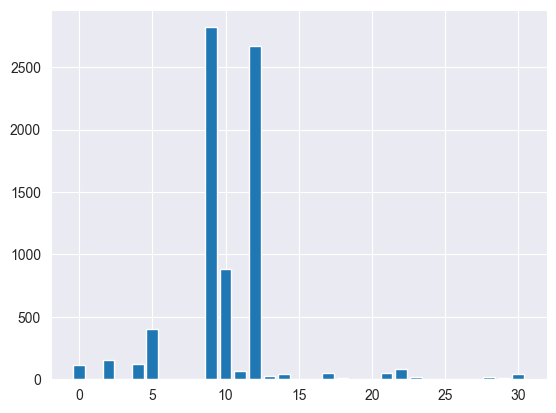

array(['3D_secured', 'weekend', 'working_day', 'amount_categories',
       'PSP_Goldcard', 'PSP_Moneycard', 'PSP_Simplecard', 'PSP_UK_Card',
       'day_of_week_5', 'day_of_week_6'], dtype=object)

In [56]:
def get_k_best_features(k, print_results=True):
    X = df_reduced.drop(columns=['success_rate'])

    # Verwendung der F-Statistik
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X, df_reduced['success_rate'])

    if print_results:
        # Ausgabe der Relevanz der einzelnen Features
        for i in range(len(selector.scores_)):
            print('Feature', X.columns[i], selector.scores_[i])

        # Erstellung des Diagramms
        plt.bar([i for i in range(len(selector.scores_))], selector.scores_)

        plt.show()

    return selector.get_feature_names_out()


get_k_best_features(10)

Da im Modell der Erfolg für unterschiedliche PSP vorhergesagt werden soll, wird nun iterativ die Menge der besten Features ermittelt, sodass alle PSP enthalten sind. Somit kann dem Modell die PSP-Information später mitgeteilt werden.

In [57]:
for i in range(4, df_reduced.drop(columns=['success_rate']).shape[1]):
    best_features = get_k_best_features(i, print_results=False)
    if 'PSP_Simplecard' in best_features and 'PSP_Moneycard' in best_features and 'PSP_Goldcard' in best_features and 'PSP_UK_Card' in best_features:
        print("Ab den ", i, " besten Features sind alle PSP enthalten.")
        break

Ab den  9  besten Features sind alle PSP enthalten.


Es ergibt sich so eine Liste von 9 Features, welche am besten für die Vorhersage geeignet sind. Die späteren Modellleistungen sollen aber auch mit weiteren Features getestet werden.

Es soll eine Funktion definiert werden, welche basierend auf den k besten Features die Aufteilung in Trainings- und Testdaten vornimmt. Auch hier wird Oversampling genutzt, um unterrepräsentierte Erfolgswahrscheinlichkeiten auszugleichen.

In [58]:
def train_test_split_with_k_best_features(k, df=df_reduced):
    # Auswahl der k besten Spalten
    X = df[get_k_best_features(k=k, print_results=False)]
    y = df['success_rate']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # Nutzen der Versuchsanzahl (1/Erfolgsquote) für das Oversampling
    oversampler = RandomOverSampler(random_state=42)

    y_temp = np.where(y_train == 0, 0, 1 / y_train).astype(int)
    X_train_oversample, y_train_oversample = oversampler.fit_resample(X_train, y_temp)
    y_train_oversample = np.where(y_train_oversample == 0.0, 0, 1 / y_train_oversample).astype(float)

    return X_train_oversample, X_test, y_train_oversample, y_test


X_train_oversample, X_test, y_train_oversample, y_test = train_test_split_with_k_best_features(10)
X_train_oversample.head()

,3D_secured,weekend,working_day,amount_categories,PSP_Goldcard,PSP_Moneycard,PSP_Simplecard,PSP_UK_Card,day_of_week_5,day_of_week_6
0,0,1,0,0,False,False,False,True,False,True
1,0,0,1,0,False,False,False,True,False,False
2,0,0,1,1,False,False,False,True,False,False
3,0,0,1,1,False,False,False,True,False,False
4,0,0,1,1,False,False,False,True,False,False


## Abschnitt 7: Entwicklung eines Modells auf Basis eines DecisionTrees
Nachfolgend wird ein Ansatz zur Modellentwicklung mit einem Entscheidungsbaum zur Regression verfolgt.
Hierbei sollen die Hyperparameter und die Feature Selection optimiert werden.

Mithilfe von GridSearch und Cross-Validation können die besten Hyperparameter für das Modell ermittelt werden.

Anmerkung: Eine vollumfängliche Cross-Validation mit weiteren Hyperparametern und Ausprägungen war mit den zur Verfügung stehenden Ressourcen auf dem Entwicklungsnotebook leider nicht möglich. Hier könnte mit mehr Ressourcen und/oder einer Remote-Ausführung auf einem leistungsstarken Server/Cluster weiter optimiert werden. Auch die Optimierung der Feature-Menge könnte so weiter verfolgt werden.

In [59]:
def apply_gridserarch_and_DT(k):
    print("DecisionTreeRegressor mit den ", k, " besten Features")

    # Erstellen des Modells
    basic_decisionTreeRegressor = DecisionTreeRegressor()

    # Festlegen der möglichen Hyperparameter
    param_grid = {"max_depth": [3, 5, 7, 10, 15, 20, 30],
                  "min_samples_split": [2, 3, 4],
                  "min_samples_leaf": [1, 2, 3, 5]}

    # Erstellen des RandomizedSearch-Objektes
    regressor = GridSearchCV(basic_decisionTreeRegressor, param_grid=param_grid, cv=5, n_jobs=-1)

    # Anwendung des RandomizedSearch
    X_train_oversample, X_test, y_train_oversample, y_test = train_test_split_with_k_best_features(k)
    search = regressor.fit(X_train_oversample, y_train_oversample)

    best_max_depth = search.best_params_['max_depth']
    best_min_samples_split = search.best_params_['min_samples_split']
    best_min_samples_leaf = search.best_params_['min_samples_leaf']

    print("best_max_depth", best_max_depth)
    print("best_min_samples_split", best_min_samples_split)
    print("best_min_samples_leaf", best_min_samples_leaf)

    # Parameterisieren des Modells
    decisionTreeRegressor = DecisionTreeRegressor(max_depth=best_max_depth,
                                                  min_samples_split=best_min_samples_split,
                                                  min_samples_leaf=best_min_samples_leaf)
    decisionTreeRegressor.fit(X_train_oversample, y_train_oversample)

    # Vorhersagen mithilfe des Modells
    predictions = decisionTreeRegressor.predict(X_test)

    # Zusammenführen der Testergebnisse
    test_results = pd.DataFrame(X_test)
    test_results['actual'] = y_test
    test_results['predicted'] = predictions

    display(test_results.head())

    print('Mean squared Error: ', metrics.mean_squared_error(predictions, y_test))
    print('Mean absolute Error: ', metrics.mean_absolute_error(predictions, y_test))

    print("-----------------------------------------------------------------------------------------")

    return decisionTreeRegressor


# Modellerstellung 
if not debug:
    model_dt_1 = apply_gridserarch_and_DT(9)
    model_dt_2 = apply_gridserarch_and_DT(20)
    model_dt_3 = apply_gridserarch_and_DT(31)

DecisionTreeRegressor mit den  9  besten Features
best_max_depth 5
best_min_samples_split 3
best_min_samples_leaf 2


,3D_secured,weekend,working_day,amount_categories,PSP_Goldcard,PSP_Moneycard,PSP_Simplecard,PSP_UK_Card,day_of_week_6,actual,predicted
42344,0,0,1,2,False,False,True,False,False,1.0,0.449118
4856,1,1,0,0,False,False,False,True,False,1.0,0.424683
59,0,0,0,1,False,False,False,True,False,0.5,0.283498
17004,0,1,0,2,False,False,False,True,False,0.0,0.235407
17920,0,0,1,4,False,False,False,True,False,0.0,0.211469


Mean squared Error:  0.1572843657526238
Mean absolute Error:  0.3399675992865882
-----------------------------------------------------------------------------------------
DecisionTreeRegressor mit den  20  besten Features
best_max_depth 7
best_min_samples_split 4
best_min_samples_leaf 5


,3D_secured,weekend,working_day,amount_categories,PSP_Goldcard,PSP_Moneycard,PSP_Simplecard,PSP_UK_Card,card_Diners,card_Master,...,day_of_week_2,day_of_week_5,day_of_week_6,day_part_afternoon,day_part_morning,month_part_end,month_part_mid,month_part_start,actual,predicted
42344,0,0,1,2,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,1.0,0.469697
4856,1,1,0,0,False,False,False,True,False,False,...,False,True,False,False,True,False,False,True,1.0,0.308775
59,0,0,0,1,False,False,False,True,False,True,...,False,False,False,False,False,False,False,True,0.5,0.231418
17004,0,1,0,2,False,False,False,True,False,False,...,False,True,False,False,False,False,True,False,0.0,0.274532
17920,0,0,1,4,False,False,False,True,False,True,...,False,False,False,False,True,True,False,False,0.0,0.279685


Mean squared Error:  0.15440832889644332
Mean absolute Error:  0.3368161069466916
-----------------------------------------------------------------------------------------
DecisionTreeRegressor mit den  31  besten Features
best_max_depth 30
best_min_samples_split 2
best_min_samples_leaf 1


,3D_secured,hour,weekend,holiday,working_day,amount_categories,country_Austria,country_Germany,country_Switzerland,PSP_Goldcard,...,day_part_afternoon,day_part_evening,day_part_morning,day_part_night,day_part_noon,month_part_end,month_part_mid,month_part_start,actual,predicted
42344,0,18,0,0,1,2,False,True,False,False,...,False,True,False,False,False,False,True,False,1.0,1.0
4856,1,7,1,0,0,0,False,False,True,False,...,False,False,True,False,False,False,False,True,1.0,1.0
59,0,1,0,1,0,1,False,True,False,False,...,False,False,False,True,False,False,False,True,0.5,0.0
17004,0,20,1,0,0,2,False,True,False,False,...,False,True,False,False,False,False,True,False,0.0,0.0
17920,0,6,0,0,1,4,True,False,False,False,...,False,False,True,False,False,True,False,False,0.0,0.0


Mean squared Error:  0.14954082970962435
Mean absolute Error:  0.1926426798137269
-----------------------------------------------------------------------------------------


## Abschnitt 8: Entwicklung eines Modells auf Basis eines Random Forest
Nachfolgend wird ein Ansatz zur Modellentwicklung mit einem Random Forest zur Regression verfolgt.
Hierbei sollen die Hyperparameter und die Feature Selection optimiert werden.

Mithilfe von GridSearch und Cross-Validation können die besten Hyperparameter für das Modell ermittelt werden.

Anmerkung: Eine vollumfängliche Cross-Validation mit weiteren Hyperparametern und Ausprägungen war mit den zur Verfügung stehenden Ressourcen auf dem Entwicklungsnotebook leider nicht möglich. Hier könnte mit mehr Ressourcen und/oder einer Remote-Ausführung auf einem leistungsstarken Server/Cluster weiter optimiert werden. Auch die Optimierung der Feature-Menge könnte so weiter verfolgt werden.

In [60]:
def apply_gridserarch_and_create_RF(k):
    print("RandomForestRegressor mit den ", k, " besten Features")

    # Erstellen des Modells
    basic_randomForest = RandomForestRegressor()

    # Festlegen der möglichen Hyperparameter
    param_grid = {"max_depth": [3, 5, 7, 10, 15, 20, 30],
                  "min_samples_split": [2, 3, 4],
                  "min_samples_leaf": [1, 2, 3, 5]}

    # Erstellen des RandomizedSearch-Objektes
    regressor = GridSearchCV(estimator=basic_randomForest, param_grid=param_grid, cv=5, n_jobs=-1)

    # Anwendung des RandomizedSearch
    X_train_oversample, X_test, y_train_oversample, y_test = train_test_split_with_k_best_features(k)
    search = regressor.fit(X_train_oversample, y_train_oversample)

    best_max_depth = search.best_params_['max_depth']
    best_min_samples_split = search.best_params_['min_samples_split']
    best_min_samples_leaf = search.best_params_['min_samples_leaf']

    print("best_max_depth", best_max_depth)
    print("best_min_samples_split", best_min_samples_split)
    print("best_min_samples_leaf", best_min_samples_leaf)

    # Parameterisieren des Modells
    randomForestRegressor = RandomForestRegressor(max_depth=best_max_depth,
                                                  min_samples_split=best_min_samples_split,
                                                  min_samples_leaf=best_min_samples_leaf)
    randomForestRegressor.fit(X_train_oversample, y_train_oversample)

    # Vorhersagen mithilfe des Modells
    predictions = randomForestRegressor.predict(X_test)

    # Zusammenführen der Testergebnisse
    test_results = pd.DataFrame(X_test)
    test_results['actual'] = y_test
    test_results['predicted'] = predictions

    display(test_results.head())

    print('Mean squared Error: ', metrics.mean_squared_error(predictions, y_test))
    print('Mean absolute Error: ', metrics.mean_absolute_error(predictions, y_test))

    print("-----------------------------------------------------------------------------------------")

    return randomForestRegressor


# Modellerstellung
if not debug:
    model_rf_1 = apply_gridserarch_and_create_RF(9)
    model_rf_2 = apply_gridserarch_and_create_RF(20)
    model_rf_3 = apply_gridserarch_and_create_RF(31)

RandomForestRegressor mit den  9  besten Features
best_max_depth 7
best_min_samples_split 2
best_min_samples_leaf 1


,3D_secured,weekend,working_day,amount_categories,PSP_Goldcard,PSP_Moneycard,PSP_Simplecard,PSP_UK_Card,day_of_week_6,actual,predicted
42344,0,0,1,2,False,False,True,False,False,1.0,0.442853
4856,1,1,0,0,False,False,False,True,False,1.0,0.459695
59,0,0,0,1,False,False,False,True,False,0.5,0.246006
17004,0,1,0,2,False,False,False,True,False,0.0,0.218693
17920,0,0,1,4,False,False,False,True,False,0.0,0.197451


Mean squared Error:  0.15669475982502656
Mean absolute Error:  0.3388918472546841
-----------------------------------------------------------------------------------------
RandomForestRegressor mit den  20  besten Features
best_max_depth 7
best_min_samples_split 4
best_min_samples_leaf 1


,3D_secured,weekend,working_day,amount_categories,PSP_Goldcard,PSP_Moneycard,PSP_Simplecard,PSP_UK_Card,card_Diners,card_Master,...,day_of_week_2,day_of_week_5,day_of_week_6,day_part_afternoon,day_part_morning,month_part_end,month_part_mid,month_part_start,actual,predicted
42344,0,0,1,2,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,1.0,0.522376
4856,1,1,0,0,False,False,False,True,False,False,...,False,True,False,False,True,False,False,True,1.0,0.296221
59,0,0,0,1,False,False,False,True,False,True,...,False,False,False,False,False,False,False,True,0.5,0.231584
17004,0,1,0,2,False,False,False,True,False,False,...,False,True,False,False,False,False,True,False,0.0,0.290621
17920,0,0,1,4,False,False,False,True,False,True,...,False,False,False,False,True,True,False,False,0.0,0.288118


Mean squared Error:  0.15290476050579216
Mean absolute Error:  0.33614717116858184
-----------------------------------------------------------------------------------------
RandomForestRegressor mit den  31  besten Features
best_max_depth 30
best_min_samples_split 4
best_min_samples_leaf 1


,3D_secured,hour,weekend,holiday,working_day,amount_categories,country_Austria,country_Germany,country_Switzerland,PSP_Goldcard,...,day_part_afternoon,day_part_evening,day_part_morning,day_part_night,day_part_noon,month_part_end,month_part_mid,month_part_start,actual,predicted
42344,0,18,0,0,1,2,False,True,False,False,...,False,True,False,False,False,False,True,False,1.0,0.981833
4856,1,7,1,0,0,0,False,False,True,False,...,False,False,True,False,False,False,False,True,1.0,0.748333
59,0,1,0,1,0,1,False,True,False,False,...,False,False,False,True,False,False,False,True,0.5,0.106220
17004,0,20,1,0,0,2,False,True,False,False,...,False,True,False,False,False,False,True,False,0.0,0.005000
17920,0,6,0,0,1,4,True,False,False,False,...,False,False,True,False,False,True,False,False,0.0,0.159833


Mean squared Error:  0.11940093121351598
Mean absolute Error:  0.2403735100391563
-----------------------------------------------------------------------------------------


## Abschnitt 9: Entwicklung eines Modells auf Basis eines Gradient-Boosting-Ansatzes
Nachfolgend wird ein Ansatz zur Modellentwicklung mit Gradient Boosting für eine Regression verfolgt.
Hierbei sollen die Hyperparameter und die Feature Selection optimiert werden.

Mithilfe von GridSearch und Cross-Validation können die besten Hyperparameter für das Modell ermittelt werden.

Anmerkung: Eine vollumfängliche Cross-Validation mit weiteren Hyperparametern und Ausprägungen war mit den zur Verfügung stehenden Ressourcen auf dem Entwicklungsnotebook leider nicht möglich. Hier könnte mit mehr Ressourcen und/oder einer Remote-Ausführung auf einem leistungsstarken Server/Cluster weiter optimiert werden. Auch die Optimierung der Feature-Menge könnte so weiter verfolgt werden.

In [61]:
def apply_gridserarch_and_create_GB(k):
    print("GradientBoostingRegressor mit den ", k, " besten Features")

    # Erstellen des Modells
    basic_gradientBoostingRegressor = GradientBoostingRegressor()

    # Festlegen der möglichen Hyperparameter
    param_grid = {"max_depth": [3, 5, 7, 10, 15, 20, 30],
                  "min_samples_split": [2, 3, 4],
                  "min_samples_leaf": [1, 2, 3, 5]}

    # Erstellen des RandomizedSearch-Objektes
    regressor = GridSearchCV(estimator=basic_gradientBoostingRegressor, param_grid=param_grid, cv=5,
                             n_jobs=-1)

    # Anwendung des RandomizedSearch
    X_train_oversample, X_test, y_train_oversample, y_test = train_test_split_with_k_best_features(k)
    search = regressor.fit(X_train_oversample, y_train_oversample)

    best_max_depth = search.best_params_['max_depth']
    best_min_samples_split = search.best_params_['min_samples_split']
    best_min_samples_leaf = search.best_params_['min_samples_leaf']

    print("best_max_depth", best_max_depth)
    print("best_min_samples_split", best_min_samples_split)
    print("best_min_samples_leaf", best_min_samples_leaf)

    # Parameterisieren des Modells
    gradientBoostingRegressor = GradientBoostingRegressor(max_depth=best_max_depth,
                                                          min_samples_split=best_min_samples_split,
                                                          min_samples_leaf=best_min_samples_leaf)
    gradientBoostingRegressor.fit(X_train_oversample, y_train_oversample)

    # Vorhersagen mithilfe des Modells
    predictions = gradientBoostingRegressor.predict(X_test)

    # Zusammenführen der Testergebnisse
    test_results = pd.DataFrame(X_test)
    test_results['actual'] = y_test
    test_results['predicted'] = predictions

    display(test_results.head())

    print('Mean squared Error: ', metrics.mean_squared_error(predictions, y_test))
    print('Mean absolute Error: ', metrics.mean_absolute_error(predictions, y_test))

    print("-----------------------------------------------------------------------------------------")

    return gradientBoostingRegressor


# Modellerstellung
if not debug:
    model_gb_1 = apply_gridserarch_and_create_GB(9)
    model_gb_2 = apply_gridserarch_and_create_GB(20)
    model_gb_3 = apply_gridserarch_and_create_GB(31)

GradientBoostingRegressor mit den  9  besten Features
best_max_depth 5
best_min_samples_split 2
best_min_samples_leaf 1


,3D_secured,weekend,working_day,amount_categories,PSP_Goldcard,PSP_Moneycard,PSP_Simplecard,PSP_UK_Card,day_of_week_6,actual,predicted
42344,0,0,1,2,False,False,True,False,False,1.0,0.450290
4856,1,1,0,0,False,False,False,True,False,1.0,0.460220
59,0,0,0,1,False,False,False,True,False,0.5,0.255396
17004,0,1,0,2,False,False,False,True,False,0.0,0.220317
17920,0,0,1,4,False,False,False,True,False,0.0,0.192407


Mean squared Error:  0.1565552435874428
Mean absolute Error:  0.3385032850036838
-----------------------------------------------------------------------------------------
GradientBoostingRegressor mit den  20  besten Features
best_max_depth 3
best_min_samples_split 2
best_min_samples_leaf 2


,3D_secured,weekend,working_day,amount_categories,PSP_Goldcard,PSP_Moneycard,PSP_Simplecard,PSP_UK_Card,card_Diners,card_Master,...,day_of_week_2,day_of_week_5,day_of_week_6,day_part_afternoon,day_part_morning,month_part_end,month_part_mid,month_part_start,actual,predicted
42344,0,0,1,2,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,1.0,0.487486
4856,1,1,0,0,False,False,False,True,False,False,...,False,True,False,False,True,False,False,True,1.0,0.354828
59,0,0,0,1,False,False,False,True,False,True,...,False,False,False,False,False,False,False,True,0.5,0.284824
17004,0,1,0,2,False,False,False,True,False,False,...,False,True,False,False,False,False,True,False,0.0,0.303050
17920,0,0,1,4,False,False,False,True,False,True,...,False,False,False,False,True,True,False,False,0.0,0.293318


Mean squared Error:  0.15459971464605293
Mean absolute Error:  0.3397040901382618
-----------------------------------------------------------------------------------------
GradientBoostingRegressor mit den  31  besten Features
best_max_depth 15
best_min_samples_split 2
best_min_samples_leaf 5


,3D_secured,hour,weekend,holiday,working_day,amount_categories,country_Austria,country_Germany,country_Switzerland,PSP_Goldcard,...,day_part_afternoon,day_part_evening,day_part_morning,day_part_night,day_part_noon,month_part_end,month_part_mid,month_part_start,actual,predicted
42344,0,18,0,0,1,2,False,True,False,False,...,False,True,False,False,False,False,True,False,1.0,1.023549
4856,1,7,1,0,0,0,False,False,True,False,...,False,False,True,False,False,False,False,True,1.0,0.967097
59,0,1,0,1,0,1,False,True,False,False,...,False,False,False,True,False,False,False,True,0.5,0.062691
17004,0,20,1,0,0,2,False,True,False,False,...,False,True,False,False,False,False,True,False,0.0,-0.028023
17920,0,6,0,0,1,4,True,False,False,False,...,False,False,True,False,False,True,False,False,0.0,-0.004723


Mean squared Error:  0.12083461182018572
Mean absolute Error:  0.22944025437320328
-----------------------------------------------------------------------------------------


## Abschnitt 10: Anwendung des Modells auf den bisherigen Datenbestand
Das Modell, welches die besten Testwerte geliefert hat, soll nun auf den Datenbestand angewandt werden, um es auf Plausibilität und Funktionalität zu prüfen.

In einem ersten Schritt sollen die Daten so aufbereitet werden, dass die unterschiedlichen PSP als Features durchgetestet werden können.
Dabei wird der komplette Datenbestand an bekannten Überweisungsgruppen einbezogen und die Erfolgsquote berechnet.

In [62]:
df_helper_sum = df_grouped[['group_id', 'success']].groupby(by=["group_id"]).sum()
df_helper_sum.rename(columns={'success': 'success_sum'}, inplace=True)
df_helper_count = df_grouped[['group_id', 'index']].groupby(by=["group_id"]).count()
df_helper_count.rename(columns={'index': 'index_count'}, inplace=True)
df_aggregated = pd.merge(df_grouped, df_helper_sum, left_on='group_id', right_on='group_id')
df_aggregated = pd.merge(df_aggregated, df_helper_count, left_on='group_id', right_on='group_id')
df_aggregated['success_rate'] = df_aggregated['success_sum'] / df_aggregated['index_count']

df_temp = add_timestamp(df_aggregated)
df_temp = add_time_columns(df_temp)
df_temp = add_day_part(df_temp)
df_temp = add_month_part(df_temp)
df_temp = add_weekend(df_temp)
df_temp = add_holidays(df_temp, print_holidays=False)
df_temp = add_working_day(df_temp)
df_temp = add_amount_categories(df_temp)
df_temp = add_one_hot_encoding(df_temp)
df_temp = remove_redundant_columns(df_temp)
df_temp = df_temp.groupby("group_id").last()
df_temp = df_temp.drop(columns=['success_sum', 'index_count', 'group_psp_key', 'success'])
df_temp.head()

,3D_secured,success_rate,hour,weekend,holiday,working_day,amount_categories,country_Austria,country_Germany,country_Switzerland,...,day_of_week_5,day_of_week_6,day_part_afternoon,day_part_evening,day_part_morning,day_part_night,day_part_noon,month_part_end,month_part_mid,month_part_start
group_id,,,,,,,,,,,,,,,,,,,,,
0,0,0.5,0,0,1,0,0,False,True,False,...,False,False,False,False,False,True,False,False,False,True
1,1,0.5,0,0,1,0,2,False,True,False,...,False,False,False,False,False,True,False,False,False,True
2,0,0.0,0,0,1,0,1,True,False,False,...,False,False,False,False,False,True,False,False,False,True
3,0,0.0,0,0,1,0,2,False,False,True,...,False,False,False,False,False,True,False,False,False,True
4,0,1.0,0,0,1,0,1,False,True,False,...,False,False,False,False,False,True,False,False,False,True


In [63]:
# Anordnung der Spalten in der für das Modell benötigten Reihenfolge
orig_df = df_temp[get_k_best_features(k=31, print_results=False)]

# Abspeichern der Vorgansinformation
df_temp_group_id = df_temp.index.values
df_temp_group_id = np.append(df_temp_group_id, df_temp_group_id)
df_temp_group_id = np.append(df_temp_group_id, df_temp_group_id)

# Abspeichern der ursprünglichen Erfolgsrate
orig_success_rate = df_temp['success_rate']
orig_success_rate = np.append(orig_success_rate, orig_success_rate)
orig_success_rate = np.append(orig_success_rate, orig_success_rate)

# Aufbereiten aller PSP-Varianten, sodass alle PSP für jeden Vorgang durchgetestet werden können
part_1 = orig_df.copy()
part_1['PSP_UK_Card'] = True
part_1['PSP_Simplecard'] = False
part_1['PSP_Goldcard'] = False
part_1['PSP_Moneycard'] = False
part_1['used_psp'] = "UK_Card"

part_2 = orig_df.copy()
part_2['PSP_Simplecard'] = True
part_2['PSP_UK_Card'] = False
part_2['PSP_Goldcard'] = False
part_2['PSP_Moneycard'] = False
part_2['used_psp'] = "Simplecard"

part_3 = orig_df.copy()
part_3['PSP_Goldcard'] = True
part_3['PSP_UK_Card'] = False
part_3['PSP_Simplecard'] = False
part_3['PSP_Moneycard'] = False
part_3['used_psp'] = "Goldcard"

part_4 = orig_df.copy()
part_4['PSP_Moneycard'] = True
part_4['PSP_UK_Card'] = False
part_4['PSP_Simplecard'] = False
part_4['PSP_Goldcard'] = False
part_4['used_psp'] = "Moneycard"

all_combinations = pd.concat([part_1, part_2])
all_combinations = pd.concat([all_combinations, part_3])
all_combinations = pd.concat([all_combinations, part_4])

all_combinations.reset_index(inplace=True)
used_psp = all_combinations['used_psp']

all_combinations.drop(columns=['used_psp', 'group_id'], inplace=True)
all_combinations.head()

,3D_secured,hour,weekend,holiday,working_day,amount_categories,country_Austria,country_Germany,country_Switzerland,PSP_Goldcard,...,day_of_week_5,day_of_week_6,day_part_afternoon,day_part_evening,day_part_morning,day_part_night,day_part_noon,month_part_end,month_part_mid,month_part_start
0,0,0,0,1,0,0,False,True,False,False,...,False,False,False,False,False,True,False,False,False,True
1,1,0,0,1,0,2,False,True,False,False,...,False,False,False,False,False,True,False,False,False,True
2,0,0,0,1,0,1,True,False,False,False,...,False,False,False,False,False,True,False,False,False,True
3,0,0,0,1,0,2,False,False,True,False,...,False,False,False,False,False,True,False,False,False,True
4,0,0,0,1,0,1,False,True,False,False,...,False,False,False,False,False,True,False,False,False,True


Nun wird das Modell, welches am besten auf den Testdaten performt hat (RandomForestRegressor mit 31 Features, max_depth=20, min_samples_split=2, min_samples_leaf=1) auf die Daten angewandt, wobei jeder PSP ausprobiert wird.

In [64]:
predictions = model_rf_3.predict(all_combinations)

all_combinations["original_success_rate"] = orig_success_rate
all_combinations["predicted_success_rate_for_psp"] = predictions
all_combinations["group_id"] = df_temp_group_id
all_combinations.head()

,3D_secured,hour,weekend,holiday,working_day,amount_categories,country_Austria,country_Germany,country_Switzerland,PSP_Goldcard,...,day_part_evening,day_part_morning,day_part_night,day_part_noon,month_part_end,month_part_mid,month_part_start,original_success_rate,predicted_success_rate_for_psp,group_id
0,0,0,0,1,0,0,False,True,False,False,...,False,False,True,False,False,False,True,0.5,0.487500,0
1,1,0,0,1,0,2,False,True,False,False,...,False,False,True,False,False,False,True,0.5,0.497500,1
2,0,0,0,1,0,1,True,False,False,False,...,False,False,True,False,False,False,True,0.0,0.492086,2
3,0,0,0,1,0,2,False,False,True,False,...,False,False,True,False,False,False,True,0.0,0.693190,3
4,0,0,0,1,0,1,False,True,False,False,...,False,False,True,False,False,False,True,1.0,0.471024,4


Nun werden die PSP pro Vorgang ausgewählt, für welche das Modell die höchste Erfolgswahrscheinlichkeit vorhersagt.

In [65]:
all_combinations["used_psp"] = used_psp
all_combinations_success_rate = all_combinations.copy()

# Sortieren nach berechneter Erfolgsquote und Auswahl des PSP mit der höchsten vorhergesagten Erfolgsquote für den jeweiligen Vorfall
all_combinations_success_rate = all_combinations_success_rate.sort_values('predicted_success_rate_for_psp',
                                                                          ascending=False).drop_duplicates(['group_id'])
all_combinations_success_rate.drop(columns=['group_id'], inplace=True)
all_combinations_success_rate.head()

,3D_secured,hour,weekend,holiday,working_day,amount_categories,country_Austria,country_Germany,country_Switzerland,PSP_Goldcard,...,day_part_evening,day_part_morning,day_part_night,day_part_noon,month_part_end,month_part_mid,month_part_start,original_success_rate,predicted_success_rate_for_psp,used_psp
68059,0,0,0,0,1,2,False,True,False,True,...,False,False,True,False,True,False,False,0.0,1.0,Goldcard
67102,0,23,1,0,0,2,False,True,False,True,...,False,False,True,False,True,False,False,0.0,1.0,Goldcard
67080,0,21,1,0,0,2,False,False,True,True,...,True,False,False,False,True,False,False,0.0,1.0,Goldcard
67081,1,21,1,0,0,0,False,False,True,True,...,True,False,False,False,True,False,False,0.0,1.0,Goldcard
67083,1,22,1,0,0,2,False,True,False,True,...,False,False,True,False,True,False,False,0.0,1.0,Goldcard


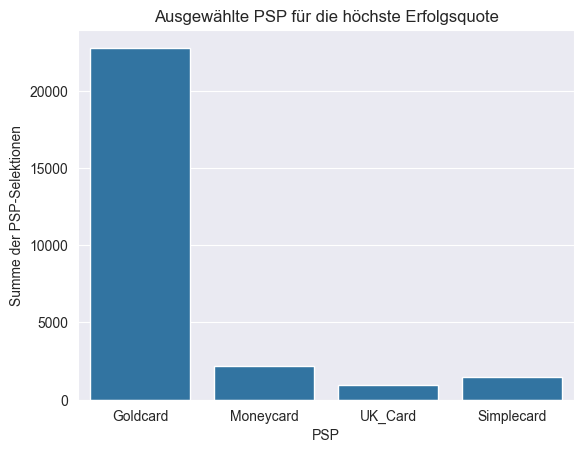

In [66]:
# Erstellung des Diagramms
sns.countplot(data=all_combinations_success_rate, x='used_psp')
# Festlegung von Titel und Label
plt.xlabel('PSP')
plt.ylabel('Summe der PSP-Selektionen')
plt.title('Ausgewählte PSP für die höchste Erfolgsquote')

plt.show()

Nun wird die Verbesserung der Erfolgsquote durch die Modellergebnisse für alle Transaktionsvorgänge berechnet.

In [67]:
print("Durchschnittliche Erfolgsquote durch fixes Regelwerk (pro Überweisungsgruppe): ",
      np.average(all_combinations_success_rate['original_success_rate']))
print("Durchschnittliche Erfolgsquote durch Nutzung der Erfolgsvorhersage bei PSP-Auswahl (pro Überweisungsgruppe): ",
      np.average(all_combinations_success_rate['predicted_success_rate_for_psp']))
print("Verbesserung der durchschnittlichen Erfolgsquote (pro Überweisungsgruppe) um: ", np.sum(
    all_combinations_success_rate['predicted_success_rate_for_psp'] - all_combinations_success_rate[
        'original_success_rate']) / all_combinations_success_rate.shape[0])

Durchschnittliche Erfolgsquote durch fixes Regelwerk (pro Überweisungsgruppe):  0.2725175078139924
Durchschnittliche Erfolgsquote durch Nutzung der Erfolgsvorhersage bei PSP-Auswahl (pro Überweisungsgruppe):  0.943275019365917
Verbesserung der durchschnittlichen Erfolgsquote (pro Überweisungsgruppe) um:  0.6707575115519245


Es werden die Kosten für die erfolgsquotengeleitete PSP-Auswahl berechnet.

In [68]:
# Definition der Kosten je PSP
costs = {"Moneycard": [5, 2],
         "Goldcard": [10, 5],
         "UK_Card": [3, 1],
         "Simplecard": [1, 0.5]}

In [69]:
# Berechnung der Kosten für die PSP-Auswahl auf Basis der Erfolgsquote auf den Originaldaten
costs_for_max_success = 0
count_no_success = 0

for index, entry in all_combinations_success_rate.iterrows():
    if entry["predicted_success_rate_for_psp"] == 0:
        costs_for_max_success = costs_for_max_success + 99
        count_no_success = count_no_success + 1
        continue
    costs_for_max_success = costs_for_max_success + (costs.get(entry['used_psp'])[0]
                                                     + (costs.get(entry['used_psp'])[1]) * (
                                                             1 / entry["predicted_success_rate_for_psp"] - 1))

print("Kosten für eine erfolgsquotengeleitete PSP-Auswahl: ", costs_for_max_success)
print("Transaktionen mit Erfolgsquote 0 für jeden PSP: ", count_no_success)

Kosten für eine erfolgsquotengeleitete PSP-Auswahl:  250625.35685342192
Transaktionen mit Erfolgsquote 0 für jeden PSP:  0


Es wird nun für jeden Transaktionsvorgang der kostengünstigste PSP ausgewählt, wobei die Kosten für erfolgreiche und nicht-erfolgreiche Transaktionen berücksichtigt werden.

In [70]:
# Berechnung der Kosten für die PSP-Auswahl auf Basis der Vorhersage auf den Originaldaten ohne Berücksichtigung einer hohen Erfolgsquote
all_combinations_costs = all_combinations.copy()
all_combinations_costs['predicted_costs'] = None

for index, entry in all_combinations.iterrows():
    if entry["predicted_success_rate_for_psp"] == 0:
        all_combinations_costs['predicted_costs'][index] = 99
        continue
    all_combinations_costs['predicted_costs'][index] = (costs.get(entry['used_psp'])[0]
                                                        + (costs.get(entry['used_psp'])[1]) * (
                                                                1 / entry["predicted_success_rate_for_psp"] - 1))

# Sortieren nach berechneten Kosten und Auswahl des günstigsten PSP für den jeweiligen Vorfall
all_combinations_costs['group_id'] = df_temp_group_id
all_combinations_costs = all_combinations_costs.sort_values('predicted_costs', ascending=True).drop_duplicates(
    ['group_id'])
all_combinations_costs.drop(columns=['group_id'], inplace=True)
all_combinations_costs.head()

,3D_secured,hour,weekend,holiday,working_day,amount_categories,country_Austria,country_Germany,country_Switzerland,PSP_Goldcard,...,day_part_morning,day_part_night,day_part_noon,month_part_end,month_part_mid,month_part_start,original_success_rate,predicted_success_rate_for_psp,used_psp,predicted_costs
49318,0,23,1,0,0,1,False,True,False,False,...,False,True,False,False,True,False,1.000000,1.0,Simplecard,1.0
44735,0,3,0,0,1,1,False,True,False,False,...,False,True,False,False,False,True,0.333333,1.0,Simplecard,1.0
52676,0,13,1,0,0,2,False,True,False,False,...,False,False,True,True,False,False,0.333333,1.0,Simplecard,1.0
48605,1,9,0,0,1,1,True,False,False,False,...,True,False,False,False,True,False,1.000000,1.0,Simplecard,1.0
29830,0,22,1,0,0,2,True,False,False,False,...,False,True,False,False,False,True,1.000000,1.0,Simplecard,1.0


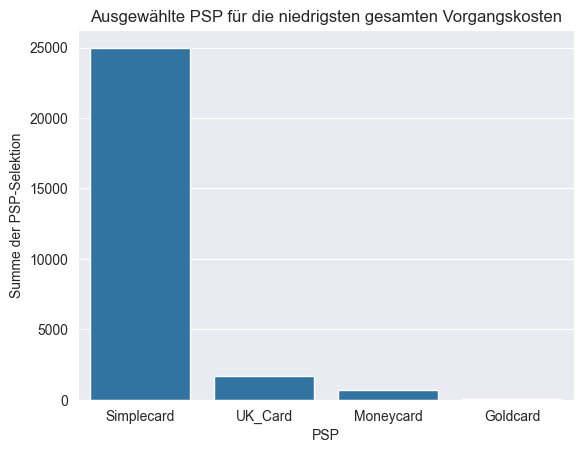

In [71]:
# Erstellung des Diagramms
sns.countplot(data=all_combinations_costs, x='used_psp')
# Festlegung von Titel und Label
plt.xlabel('PSP')
plt.ylabel('Summe der PSP-Selektion')
plt.title('Ausgewählte PSP für die niedrigsten gesamten Vorgangskosten')

plt.show()

In [72]:
# Addition der Kosten für die PSP-Auswahl auf Basis der Vorhersagen auf den Originaldaten
new_costs = 0

for index, entry in all_combinations_costs.iterrows():
    new_costs = new_costs + entry['predicted_costs']

print("Kosten (optimiert): ", new_costs)
print("Transaktionen mit Erfolgsquote 0 für jeden PSP: ",
      np.sum(np.where(all_combinations_costs['predicted_costs'] == 99, 1, 0)))
print("Durchschnittlicher Transaktionserfolg (pro Überweisungsgruppe): ", np.average(all_combinations_costs['predicted_success_rate_for_psp']))

Kosten (optimiert):  53444.712917799705
Transaktionen mit Erfolgsquote 0 für jeden PSP:  0
Durchschnittlicher Transaktionserfolg (pro Überweisungsgruppe):  0.5526344443723701


In [73]:
# Berechnung der Kosten für die PSP-Auswahl auf Basis des festen Regelwerkes auf den Originaldaten
original_costs = 0

for index, entry in df_original.iterrows():
    original_costs = original_costs + (costs.get(entry['PSP'])[(entry['success'] - 1) * -1])

print("Kosten (original): ", original_costs)

Kosten (original):  88544.0
